### Imports

In [ ]:
pip install pandas seaborn scipy torch scikit-learn pytorch_forecasting pytorch_lightning lightgbm xgboost statsmodels optuna plotly

In [100]:
# -------------------------------------------
# Imports & notebook housekeeping
# -------------------------------------------

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------
from datetime import datetime
import itertools
import calendar as cal                   # weekday / month names
import scipy.stats as stats              # normality, skew, etc.
from scipy import stats as sc_stats


# -------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import lightgbm as lgb                   # gradient boosting (fast baseline)
import xgboost as xgb                    # alternative GBM
# import prophet                          # uncomment if you want fbprophet
import statsmodels.api as sm            # ARIMA, ETS, SARIMAX, etc.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
import optuna

# -------------------------------------------
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE

import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from lightning.pytorch import Trainer

# -------------------------------------
import plotly.express as px              # interactive EDA
import plotly.graph_objects as go

# -------------------------------------------
# Reproducibility
SEED = 42
np.random.seed(SEED)

# -------------------------------------------
# Nice-to-have settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")          # comment out if you prefer default
# # keep this line by itself if you want explicit inline plotting
# %matplotlib inline

# -------------------------------------------
# Wider, higher-res plots for Matplotlib
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 110

In [2]:
# -------------------------------------------
# File locations
# -------------------------------------------]

DATA_PATH = Path("data")            # adjust if our folder is elsewhere

train_path      = DATA_PATH / "train.csv"
calendar_path   = DATA_PATH / "calendar_events.csv"
submission_path = DATA_PATH / "forecast_submission.csv"

### Loading the existing data

In [39]:
# -------------------------------------------
# Load raw CSVs
# -------------------------------------------
train_df    = pd.read_csv(train_path,    parse_dates=["date"])
calendar_df = pd.read_csv(calendar_path, parse_dates=["date"])
test_df     = pd.read_csv(submission_path)   # 'id' encodes date

# Deduplicate (defensive; raw file *should* be clean)
dup_cnt = train_df.duplicated(subset=["store_id", "date"]).sum()
if dup_cnt:
    print(f"⚠️  Found {dup_cnt:,} duplicate store-day rows – aggregating.")
    train_df = (train_df
                .groupby(["store_id", "date"], as_index=False, sort=True)
                .agg({"revenue": "sum"}))

print("Train shape after dedup :", train_df.shape)
display(train_df)
display(calendar_df)
display(test_df)


# -------------------------------------------
# Merge calendar ‘event’ + helper columns
# -------------------------------------------
full_df = (
    train_df.merge(calendar_df, on="date", how="left")      # adds `event`
            .assign(
                dow         = lambda d: d.date.dt.dayofweek,   # 0=Mon … 6=Sun
                month       = lambda d: d.date.dt.month,
                is_zero_day = lambda d: (d.revenue == 0).astype(int)
            )
)

# -------------------------------------------
# Build ±3-day window flags (wide pivot, NO extra rows)
# -------------------------------------------
# create lead/lag columns in the calendar table
cal_shift = calendar_df.copy()
for k in range(1, 4):
    cal_shift[f'event_lead{k}'] = cal_shift['event'].shift(-k)   # k days BEFORE
    cal_shift[f'event_lag{k}']  = cal_shift['event'].shift( k)   # k days AFTER

# pivot so each offset is its own column -> still 1 row per date
lead_lag_cols = [c for c in cal_shift.columns if 'lead' in c or 'lag' in c]
cal_wide = cal_shift[['date'] + lead_lag_cols]

# merge (still one row per date)
full_df = full_df.merge(cal_wide, on="date", how="left")

print("Full DF shape :", full_df.shape)        # should still be 18 766 × (…)
print("Unique (store,date) pairs:", full_df[['store_id','date']].duplicated().sum())
display(full_df)


# -------------------------------------------
# Persist snapshot for all downstream work
# -------------------------------------------
out_path = DATA_PATH / "full_train.pkl"
full_df.to_pickle(out_path)
print(f"✅  Saved merged & enriched train to {out_path}")

Train shape after dedup : (18766, 4)


,store_id,store_name,date,revenue
0,0,All Stores,2011-01-29,204126.52
1,0,All Stores,2011-01-30,197426.42
2,0,All Stores,2011-01-31,144267.27
3,0,All Stores,2011-02-01,151903.00
4,0,All Stores,2011-02-02,117399.88
...,...,...,...,...
18761,10,Wisconsin – Badger Crossing,2015-09-26,25689.55
18762,10,Wisconsin – Badger Crossing,2015-09-27,26557.53
18763,10,Wisconsin – Badger Crossing,2015-09-28,19067.53
18764,10,Wisconsin – Badger Crossing,2015-09-29,16467.95


,date,event
0,2011-02-06,SuperBowl
1,2011-02-14,ValentinesDay
2,2011-02-21,PresidentsDay
3,2011-03-09,LentStart
4,2011-03-16,LentWeek2
...,...,...
157,2016-05-08,Mother's day
158,2016-05-30,MemorialDay
159,2016-06-02,NBAFinalsStart
160,2016-06-07,Ramadan starts


,id,prediction
0,0_20151001,0
1,0_20151002,0
2,0_20151003,0
3,0_20151004,0
4,0_20151005,0
...,...,...
1007,10_20151227,0
1008,10_20151228,0
1009,10_20151229,0
1010,10_20151230,0


Full DF shape : (18766, 14)
Unique (store,date) pairs: 0


,store_id,store_name,date,revenue,event,dow,month,is_zero_day,event_lead1,event_lag1,event_lead2,event_lag2,event_lead3,event_lag3
0,0,All Stores,2011-01-29,204126.52,NaN,5,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,All Stores,2011-01-30,197426.42,NaN,6,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,All Stores,2011-01-31,144267.27,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,All Stores,2011-02-01,151903.00,NaN,1,2,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,All Stores,2011-02-02,117399.88,NaN,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18761,10,Wisconsin – Badger Crossing,2015-09-26,25689.55,NaN,5,9,0,NaN,NaN,NaN,NaN,NaN,NaN
18762,10,Wisconsin – Badger Crossing,2015-09-27,26557.53,NaN,6,9,0,NaN,NaN,NaN,NaN,NaN,NaN
18763,10,Wisconsin – Badger Crossing,2015-09-28,19067.53,NaN,0,9,0,NaN,NaN,NaN,NaN,NaN,NaN
18764,10,Wisconsin – Badger Crossing,2015-09-29,16467.95,NaN,1,9,0,NaN,NaN,NaN,NaN,NaN,NaN


✅  Saved merged & enriched train to data\full_train.pkl


In [4]:
# Helper function to make a Kaggle submission file
def make_submission(preds, template_path="data/forecast_submission.csv",
                    out_path="my_submission.csv"):
    """
    Put predictions into exact Kaggle format and save the CSV.
    Assumes `preds` are in the **same order** as rows in the template.
    """
    template = pd.read_csv(template_path)
    if len(preds) != len(template):
        raise ValueError(f"Row-count mismatch: {len(preds)=}, "
                         f"{len(template)=}")
    sub = template.copy()
    sub["prediction"] = np.asarray(preds).ravel()
    sub.to_csv(out_path, index=False)
    print(f"✅  Saved {out_path}  ({len(sub):,} rows)")
    return sub

### Understand the Data & Hierarchy

In [6]:
# unique store ids
print("Store IDs:", sorted(train_df.store_id.unique()))

Store IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [7]:
# aggregate consistency check (check if all stores revenues are correct according to the sum of all independent stores)
total_vs_sum = (
    train_df.query("store_id == 0")
            .set_index("date")["revenue"]
    - train_df.query("store_id != 0")
             .groupby("date")["revenue"].sum()
)
print("Max absolute diff agg vs sum:", total_vs_sum.abs().max())

Max absolute diff agg vs sum: 0.03999999997904524


In [8]:
# date continuity gaps (checks for missing dates in each store)
gaps = {}
for sid, grp in train_df.groupby("store_id"):
    # focus on the revenue Series only
    has_gap = (
        grp.set_index("date")["revenue"]   # <-- pick the column
           .asfreq("D")
           .isna()
           .any()                          # now a single bool
    )
    if has_gap:
        gaps[sid] = grp

print("Stores with gaps:", list(gaps.keys()))

Stores with gaps: []


In [40]:
# number of days with exact 0 revenue
zero_ratio = (
    train_df.assign(is_zero = lambda d: d.revenue == 0)
            .groupby("store_id").is_zero.mean()
            .mul(100).round(2)
)
display(zero_ratio.to_frame("pct_zero_days"))

,pct_zero_days
store_id,
0,0.00
1,0.23
2,0.00
3,0.06
4,0.23
5,0.18
6,0.12
7,0.00
8,0.18


In [41]:
# check when each store start and end date
span = train_df.groupby("store_id").date.agg(['min','max'])
display(span)

,min,max
store_id,,
0,2011-01-29,2015-09-30
1,2011-01-29,2015-09-30
2,2011-01-29,2015-09-30
3,2011-01-29,2015-09-30
4,2011-01-29,2015-09-30
5,2011-01-29,2015-09-30
6,2011-01-29,2015-09-30
7,2011-01-29,2015-09-30
8,2011-01-29,2015-09-30


In [42]:
# Leap-year row check
for sid in full_df.store_id.unique():
    assert pd.Timestamp('2012-02-29') in full_df.query("store_id==@sid").date.values

### Data exploration

####  Daily revenue lines, faceted by store_id

**Take-aways**

Trend: every store shows a roughly monotonic rise—good evidence of macro growth.

Weekly pulses: the saw-tooth pattern hints at a strong weekday/weekend cycle.

Data gaps/outliers: vertical drops to (almost) zero on identical dates across stores—likely system outages or missing-data days; we should flag or impute them.

Scale differences: store 0 dwarfs the others, confirming it’s the aggregate series (see Q&A at bottom).


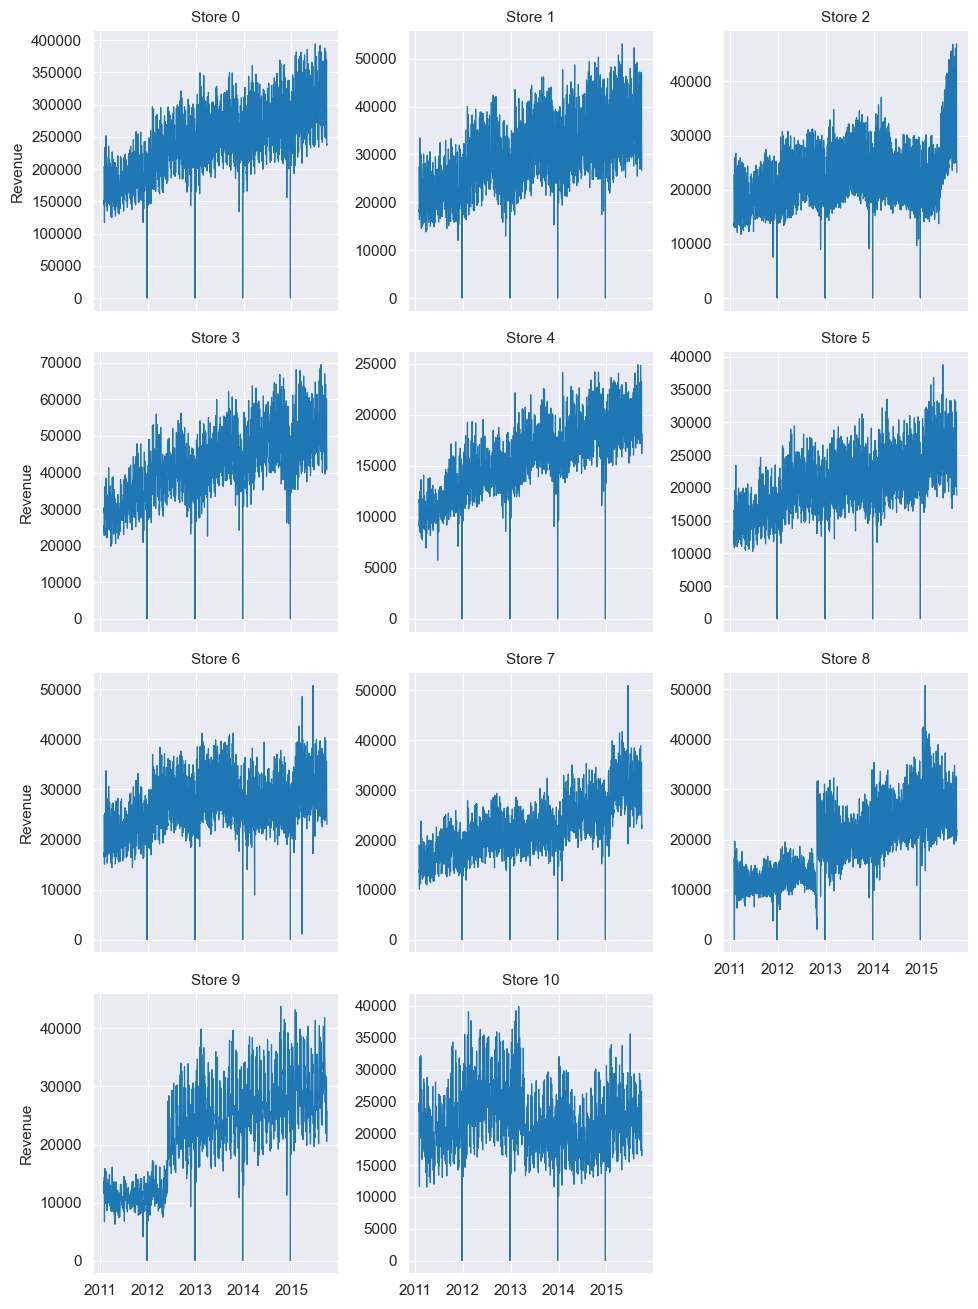

In [43]:
# -----------------------------------------------------------
# Daily revenue lines, faceted by store_id
# -----------------------------------------------------------

g = sns.FacetGrid(
    data=train_df,
    col="store_id",
    col_wrap=3,        # 3 columns per row
    height=3,
    sharey=False
)
g.map_dataframe(sns.lineplot, x="date", y="revenue", lw=0.8)
g.set_titles("Store {col_name}")
g.set_axis_labels("", "Revenue")
plt.tight_layout()
plt.show()

#### 30-day moving average vs. raw daily series (example: store 0)

**Take-aways**

* needs to expect all the stores to be present, not just store 0

Structural trend: 30-day MA climbs from ~180 k → 310 k, confirming long-term growth.

Seasonal bumps: gentle yearly waves (likely Q4 holiday lift).

Extreme troughs: the periodic near-zero spikes match the outages seen above—helps decide outlier handling.


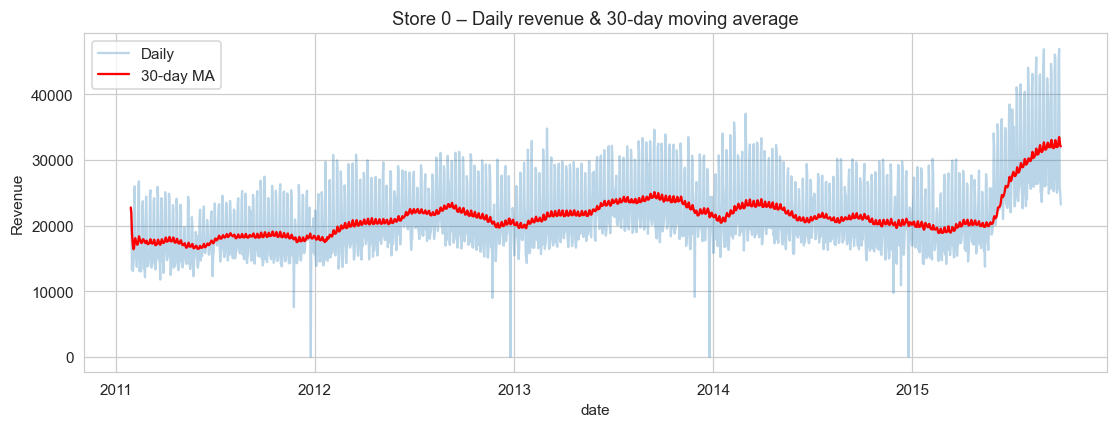

In [14]:
# -----------------------------------------------------------
# Moving average overlay for the "all-stores" series (store_id 0)
# -----------------------------------------------------------
store0 = (
    train_df.loc[train_df.store_id == 2]
            .sort_values("date")
            .assign(ma_30=lambda d: d.revenue.rolling(30, min_periods=1).mean())
)

plt.figure(figsize=(12,4))
sns.lineplot(data=store0, x="date", y="revenue", alpha=0.3, label="Daily")
sns.lineplot(data=store0, x="date", y="ma_30",        color="red", label="30-day MA")
plt.title("Store 0 – Daily revenue & 30-day moving average")
plt.ylabel("Revenue")
plt.show()

#### Weekday pattern (all stores combined)

**Take-aways**

Weekend premium: Sat/Sun medians roughly 25 % higher than mid-week.

Friday build-up: Friday sits between weekdays and weekends—useful for lag features.

Monday rebound: Monday median still higher than Tue–Thu—interesting after-weekend catch-up.

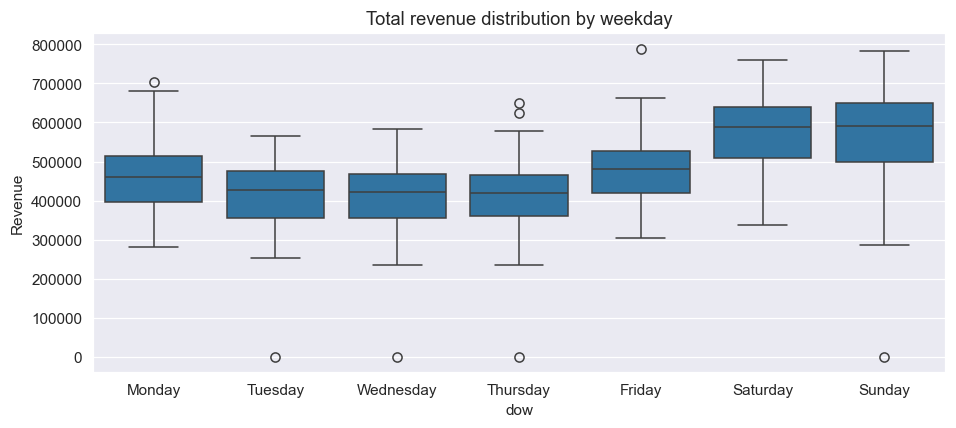

In [44]:
# -----------------------------------------------------------
# Box-plot by day-of-week
# -----------------------------------------------------------
weekday_df = (
    train_df.assign(dow=train_df.date.dt.day_name())
            .groupby(["dow", "date"]).revenue.sum().reset_index()  # total across stores
)
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

plt.figure(figsize=(10,4))
sns.boxplot(data=weekday_df, x="dow", y="revenue", order=order)
plt.title("Total revenue distribution by weekday")
plt.ylabel("Revenue")
plt.show()

#### Month-over-month total revenue (stacked by store)

**Take-aways**

Growth slope: aggregate monthly revenue ~doubles over 5 years, confirms non-stationarity.

Store mix stability: colour bands keep their thickness ~constant → stores grow proportionally; no single store overtakes others (apart from store 0’s built-in dominance).

Holiday peak: one large spike Q4-2013; cross-check with calendar_events.


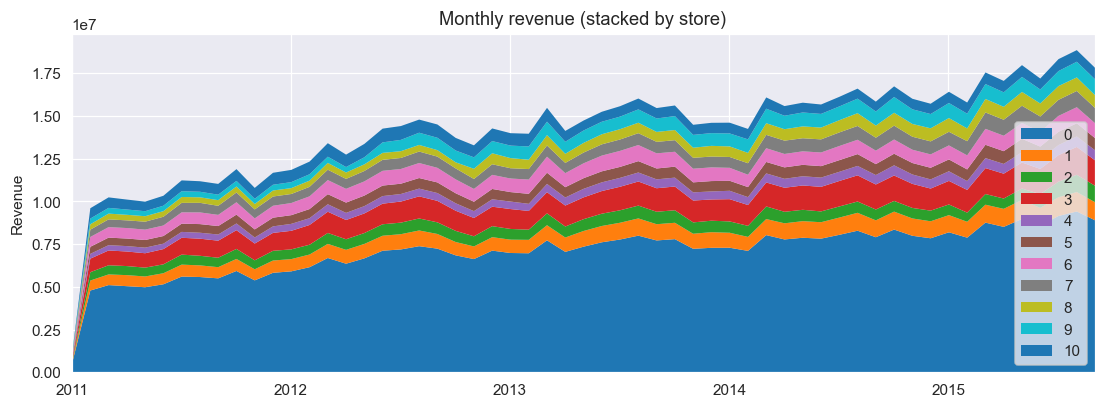

In [45]:
# -----------------------------------------------------------
# Monthly totals pivoted wide → stacked area chart
# -----------------------------------------------------------
monthly_totals = (
    train_df.assign(ym=train_df.date.dt.to_period("M"))
            .groupby(["ym", "store_id"]).revenue.sum()
            .unstack("store_id")
            .rename_axis(index=None, columns=None)
)
monthly_totals.index = monthly_totals.index.to_timestamp()  # Period → Timestamp

monthly_totals.plot.area(figsize=(12,4), stacked=True, linewidth=0)
plt.title("Monthly revenue (stacked by store)")
plt.ylabel("Revenue")
plt.show()

#### Holiday / special-event impact scatter

**Take-aways**

* not too understandable plot needs to be addapted

Positive lift: most coloured markers sit high above the daily baseline—events ≈ sales boosters.

Event variance: some events cluster lower, meaning not every holiday helps (e.g., minor state holidays).

Missing labels: a few natural peaks lack an event tag—maybe promo periods worth creating custom flags for (e.g., “Back-to-School” week).


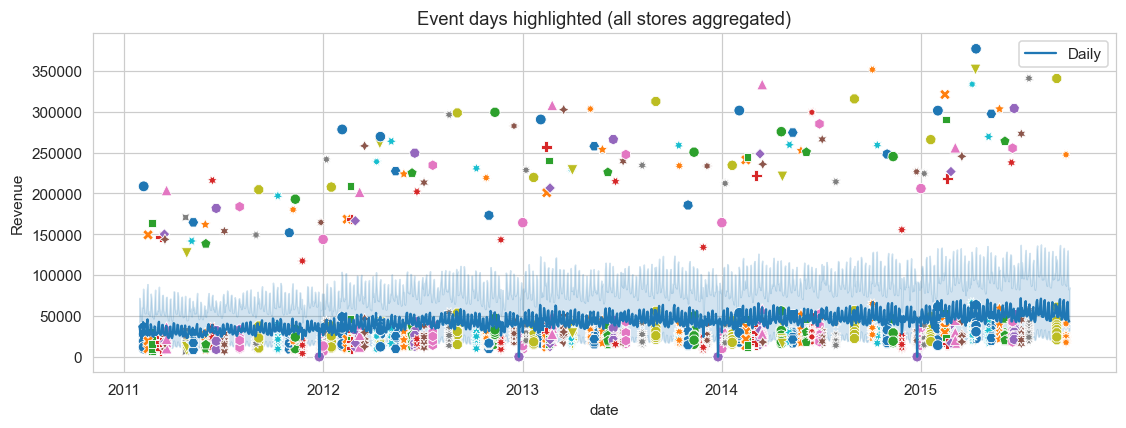

In [17]:
# -----------------------------------------------------------
# Overlay known events on the daily series
# -----------------------------------------------------------
# Merge event labels onto train_df
events = calendar_df.rename(columns={"event": "event_name"})
tmp = train_df.merge(events, on="date", how="left")

plt.figure(figsize=(12,4))
sns.lineplot(data=tmp, x="date", y="revenue", label="Daily")
sns.scatterplot(
    data=tmp[tmp.event_name.notna()],
    x="date", y="revenue",
    hue="event_name", style="event_name",
    palette="tab10", legend=False, s=50
)
plt.title("Event days highlighted (all stores aggregated)")
plt.ylabel("Revenue")
plt.show()

### Uplift bar chart – How much does each event lift sales overall?

**take aways:**
- Only a handful of holidays generate > 5 k lift in the aggregate series.
→ worth creating explicit binary features (is_superbowl, is_easter_week, …).
- Religious holidays (Easter variants, Eid, Ramadan) and U.S. social events (Super Bowl, Father’s Day) dominate; Independence Day is not top-15—interesting anomaly to double-check.
- Since values are absolute dollar, the effect on individual stores will be smaller; we need a per-store view.

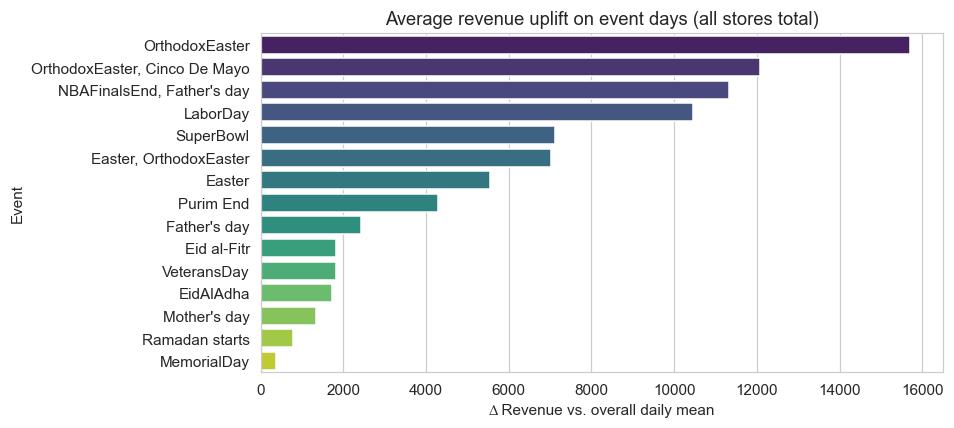

In [18]:
# -----------------------------------------------------------
# 1. Compute uplift = event_day_mean - non_event_mean
# -----------------------------------------------------------
df = train_df.merge(calendar_df, on="date", how="left")

overall_mean = df["revenue"].mean()

uplift = (
    df.groupby("event")["revenue"]
      .mean()
      .sub(overall_mean)             # absolute difference
      .sort_values(ascending=False)
      .head(15)                      # top 15 events
)

# -----------------------------------------------------------
# 2. Plot
# -----------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(y=uplift.index, x=uplift.values, palette="viridis")
plt.title("Average revenue uplift on event days (all stores total)")
plt.xlabel("∆ Revenue vs. overall daily mean")
plt.ylabel("Event")
plt.show()

### “Per-store heat-map” – Which stores benefit from which events?

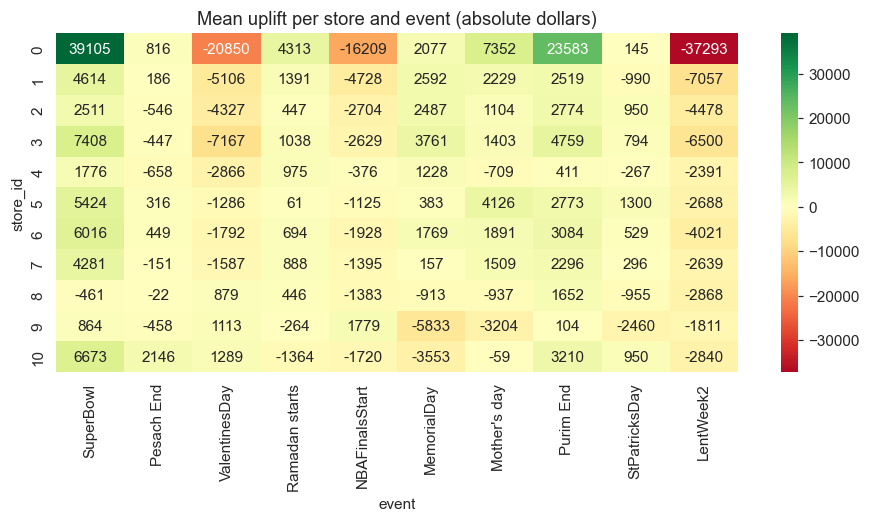

In [19]:
# -----------------------------------------------------------
# 1. Build a pivot table: store_id × event_name
# -----------------------------------------------------------
pivot = (
    df.groupby(["store_id", "event"])["revenue"]
      .mean()
      .unstack("event")                          # columns = events
      .sub(df.groupby("store_id")["revenue"].mean(), axis=0)  # centre per-store
)

# -----------------------------------------------------------
#2. Keep most frequent events to avoid giant table
# -----------------------------------------------------------
top_events = (
    calendar_df["event"]
      .value_counts()
      .head(10)                # pick 10 busiest holidays
      .index
)
pivot = pivot[top_events]

# -----------------------------------------------------------
# 3. Plot heat-map
# -----------------------------------------------------------
plt.figure(figsize=(10,4))
sns.heatmap(pivot, cmap="RdYlGn", center=0, annot=True, fmt=".0f")
plt.title("Mean uplift per store and event (absolute dollars)")
plt.ylabel("store_id")
plt.show()

### Simple outlier screen (per-store whiskers)

**Take-aways**


Scale heterogeneity: store 0 median ≈ 250 k, others 20–60 k → models need either per-store scaling or loss weighting.

Outliers: whiskers extend to zero for all stores—same outage issue; high-end outliers <2 % of points → decide whether to leave or cap.

Skew: slight positive skew for most stores, so a log1p transform could help tree-based models.


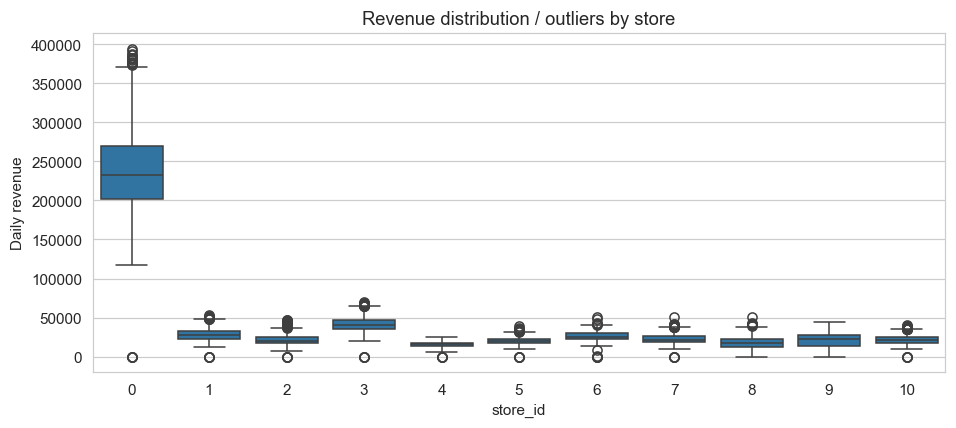

In [20]:
# -----------------------------------------------------------
# Revenue box-plot per store for outlier detection
# -----------------------------------------------------------
plt.figure(figsize=(10,4))
sns.boxplot(data=train_df, x="store_id", y="revenue")
plt.title("Revenue distribution / outliers by store")
plt.ylabel("Daily revenue")
plt.show()

#### ACF/PACF on log-transformed revenues

**Key Takeaways**:

- Weekly seasonality is dominant:

Regular spikes every 7 lags in the ACF (and corresponding seasonal spike in the PACF) confirm a strong 7-day cycle.
→ Include lag 7/14/21 features and set seasonal_period=7 in SARIMA/ETS.

- Short-range memory is modest:

PACF shows one large spike at lag 1, then drops sharply.
→ An AR(1) (plus seasonal AR(1)) is probably enough; ML models just need lag_1.

- Series are still non-stationary in level:

ACF decays slowly rather than cutting off, indicating trend.
→ Use first-differencing or let STL/Prophet remove the trend; keep a time index for tree/NN models.

- Pattern is consistent across hierarchy:

Store 0 (aggregate) and Store 3 (typical branch) look almost identical.
→ One global model with a store_id categorical can share the same seasonal features; no need for custom seasonality per store.

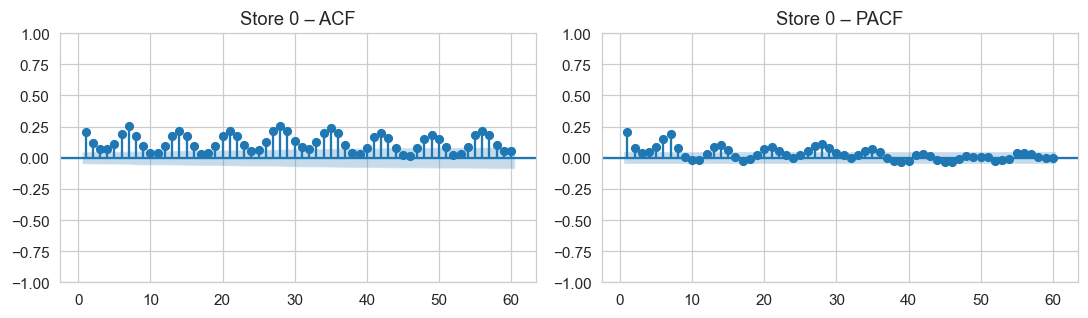

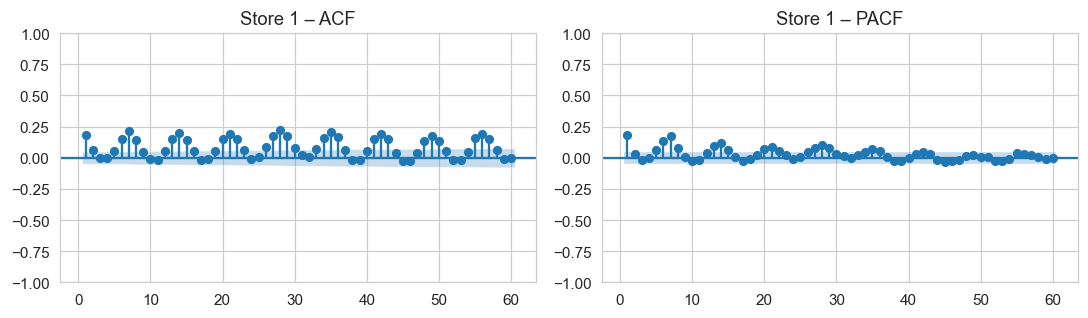

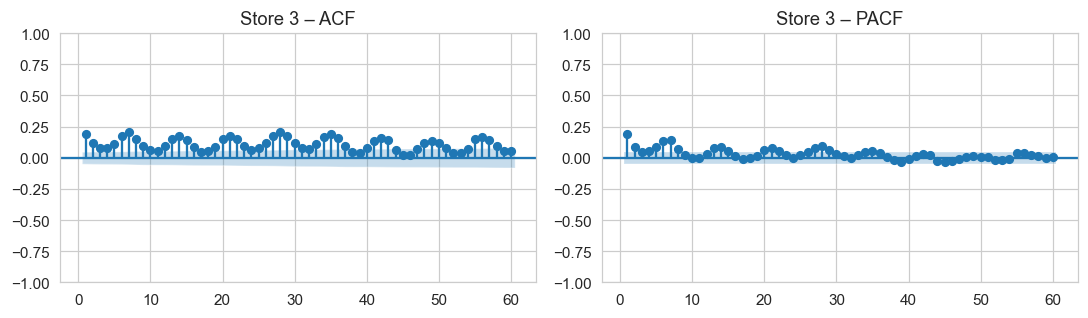

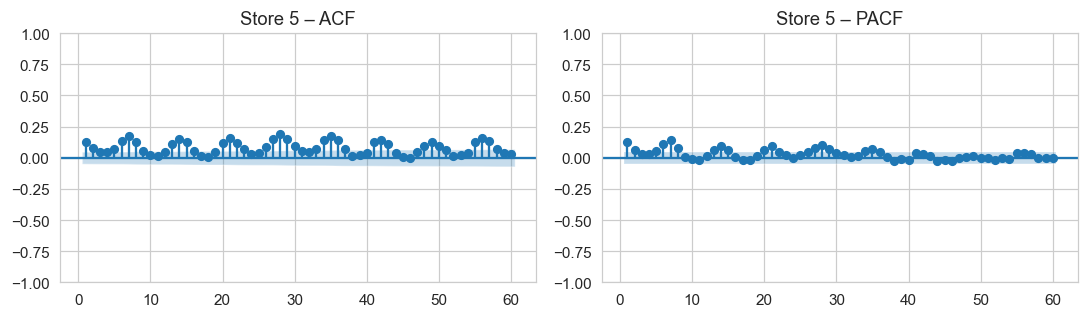

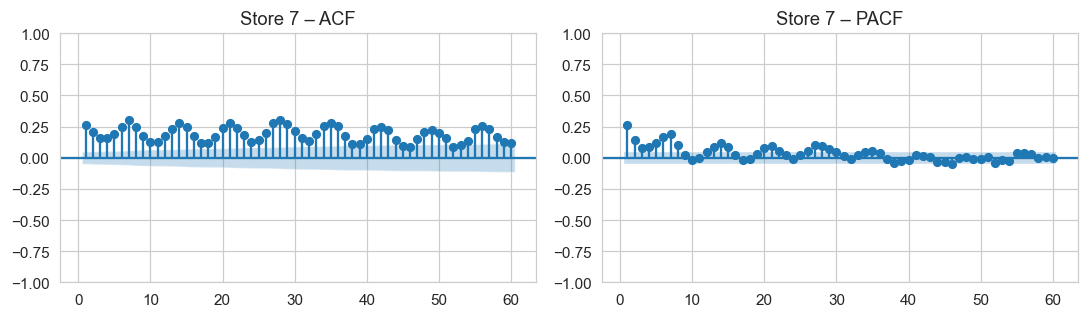

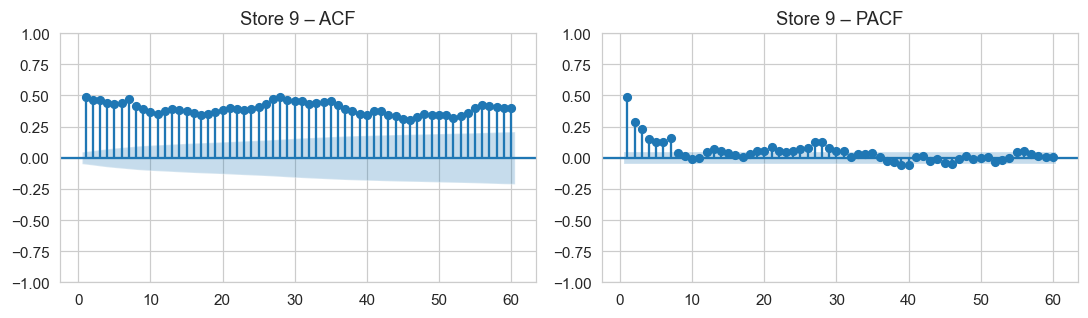

In [21]:
def acf_pacf_plots(store_id, lags=60):
    """Show ACF & PACF on log1p(revenue) for the selected store."""
    series = (
        full_df.query("store_id == @store_id")
               .sort_values("date")             # ensure true time order
               .set_index("date")["revenue"]    # keep zeros; only real NaNs are dropped
               .dropna()
               .pipe(np.log1p)
    )

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    plot_acf(series,  lags=lags, zero=False, ax=ax[0])
    plot_pacf(series, lags=lags, zero=False, ax=ax[1])
    ax[0].set_title(f"Store {store_id} – ACF")
    ax[1].set_title(f"Store {store_id} – PACF")
    plt.tight_layout()
    plt.show()

# run on aggregate + several representative stores
for sid in [0, 1, 3, 5, 7, 9]:
    acf_pacf_plots(sid)

#### Seasonal–sub-series plots

- The bar charts validate the interpretations we drew from ACF/PACF:
    - dominant weekly cycle.
    - mild but present annual drift.
    - pattern shared across stores.

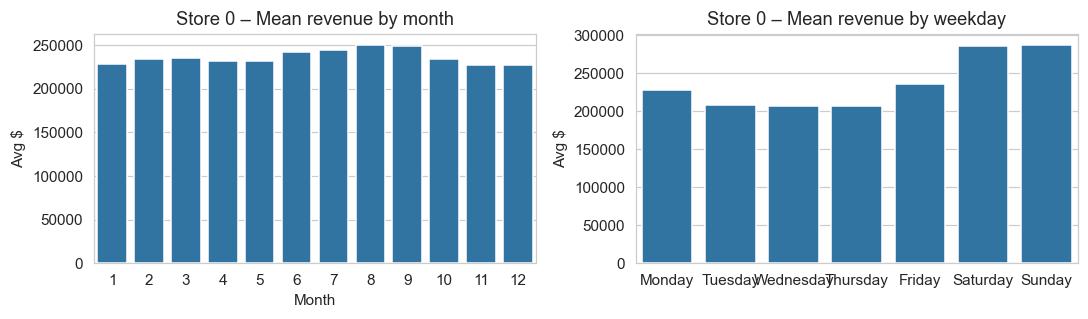

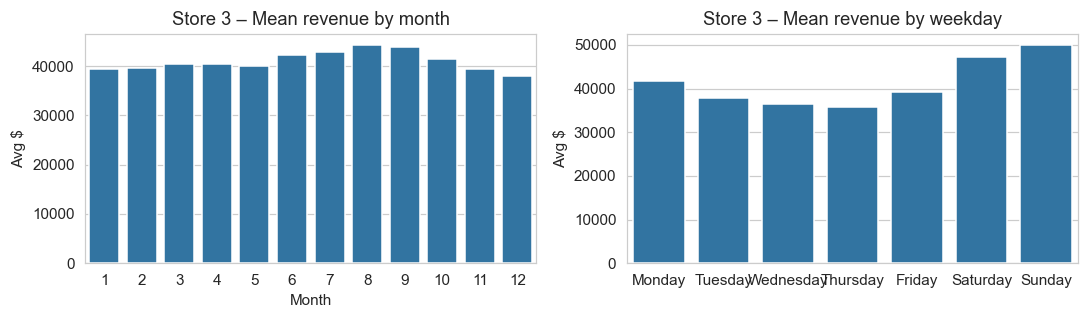

In [22]:
# choose a representative individual store (e.g. 3) and the aggregate (0)
TARGET_STORES = [0, 3]

for sid in TARGET_STORES:
    s = full_df.query("store_id == @sid")

    # ----- Month–of–year profile -------------------------------------------
    moy = (
        s.assign(month=s.date.dt.month)
         .groupby("month").revenue.mean()
    )

    # ----- Day-of-week profile --------------------------------------------
    dow = (
        s.assign(dow=s.date.dt.day_name())
         .groupby("dow").revenue.mean()
         .reindex(["Monday","Tuesday","Wednesday",
                   "Thursday","Friday","Saturday","Sunday"])
    )

    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    sns.barplot(x=moy.index, y=moy.values, ax=ax[0])
    ax[0].set_title(f"Store {sid} – Mean revenue by month")
    ax[0].set_xlabel("Month");  ax[0].set_ylabel("Avg $")

    sns.barplot(x=dow.index, y=dow.values, ax=ax[1])
    ax[1].set_title(f"Store {sid} – Mean revenue by weekday")
    ax[1].set_xlabel("");       ax[1].set_ylabel("Avg $")
    plt.tight_layout(); plt.show()

#### Log 1 + p(revenue) histogram
we are doing it to:
1. Stabilises variance
2. Tame right-skew & outliers
3. Handle multiplicative effects naturally
4. Reduce heteroscedasticity in residuals
5. It is safe with zeros via log1p
6. Easy to invert for submission

- **Variance now tamed**:

After the log1p transform the bulk of points (stores 1-10) forms a neat bell-shaped bump ≈ 10 on the x-axis → modelling on log scale should give more stable gradients and a metric (RMSE) that isn’t dominated by extreme spikes.

- **Tiny spike at 0 = rare closure/outage days:**

Those exact-zero rows are < 0.3 % of the data; keep them as zeros and pass a binary is_zero_day flag. No special zero-inflated model needed.

- **Right-hand hump ≈ 12–13 comes from store 0 (aggregate) + holiday peaks:**

Confirms large scale gap between the all-stores series (~ 220 k dollars per day) and individual stores (~ 22 k dollars).

- **Modelling implication:**

- use store_id as a categorical feature (or train a separate model for store 0) so the learner can treat scales differently; otherwise the global loss may over-focus on store 0.

- **No intermittent-demand issue:**

Because virtually all days have positive sales, we don’t need Croston-type methods or zero-inflated objectives—standard Tweedie/Poisson or plain RMSE is fine.

- **Decision locked-in:**
-
log1p(revenue) will be our target for ML / DL models, with an inverse transform (expm1) right before submission.

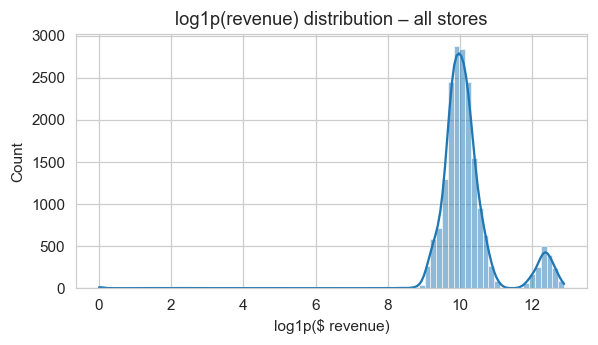

In [23]:
# ------------------------------------------------------------------
# Inspect log1p distribution to decide on variance stabilisation on all stores
# ------------------------------------------------------------------
plt.figure(figsize=(6,3))
sns.histplot(np.log1p(full_df.revenue), bins=80, kde=True)
plt.title("log1p(revenue) distribution – all stores")
plt.xlabel("log1p($ revenue)")
plt.show()

#### Per-store variance & skew table  (log1p + raw for comparison)

In [24]:
# ------------------------------------------------------------------
# Per-store variance & skew table  (log1p + raw for comparison)
# ------------------------------------------------------------------
var_skew_tbl = (
    full_df.assign(log_rev=lambda d: np.log1p(d.revenue))
           .groupby("store_id")
           .agg(raw_mean = ('revenue', 'mean'),
                raw_var  = ('revenue', 'var'),
                raw_skew = ('revenue', sc_stats.skew),
                log_mean = ('log_rev',  'mean'),
                log_var  = ('log_rev',  'var'),
                log_skew = ('log_rev',  sc_stats.skew))
           .round(2)
)
display(var_skew_tbl)

,raw_mean,raw_var,raw_skew,log_mean,log_var,log_skew
store_id,,,,,,
0,237057.45,2.984826e+09,0.15,12.33,0.20,-13.19
1,28756.90,5.954453e+07,0.39,10.21,0.32,-14.11
2,21393.61,3.408220e+07,0.97,9.92,0.18,-10.87
3,41134.34,8.537632e+07,0.08,10.58,0.23,-14.82
4,15469.16,1.186658e+07,-0.15,9.60,0.27,-14.94
5,20081.25,2.243485e+07,0.34,9.86,0.26,-14.81
6,26304.04,3.260776e+07,0.18,10.14,0.22,-15.08
7,22268.39,3.354563e+07,0.47,9.96,0.20,-11.48
8,18289.56,4.998661e+07,0.55,9.72,0.39,-8.83


#### STL decomposition (weekly seasonality)

- Trend panel – smooth upward slope across all stores ⇒ long-run growth; sudden dips match the rare outage/closure days.

- Seasonal (period = 7) – clean, sine-like weekly wave (peaks on Sat/Sun, trough mid-week); amplitude is stable over the 5 years.
→ captures the strong 7-day cycle already seen in ACF/PACF.

- Remainder / Residual – mostly white-noise cloud; big positive spike the day after an outage (catch-up sales).
Stationarity tests (ADF ≪ 0.05 & KPSS ≈ 0.10) confirm these residuals are stationary, so no extra differencing is needed for ARIMA-type baselines.

**Implications:**
1. Weekly dummies or lag-7 features are essential; yearly effects are mild and can be handled with simple month/Fourier terms.
2. Models should include a time-index or growth component for the monotonic trend.
3. Outage days can stay as zeros, but flagging them (is_zero_day) helps ML models learn the rebound that follows.

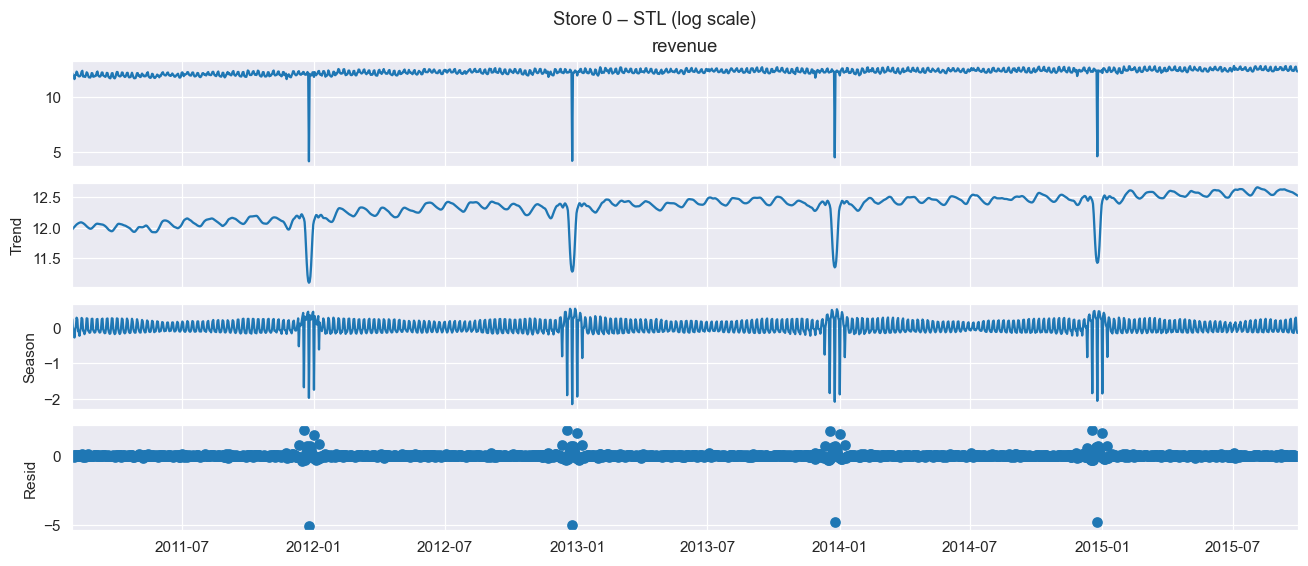

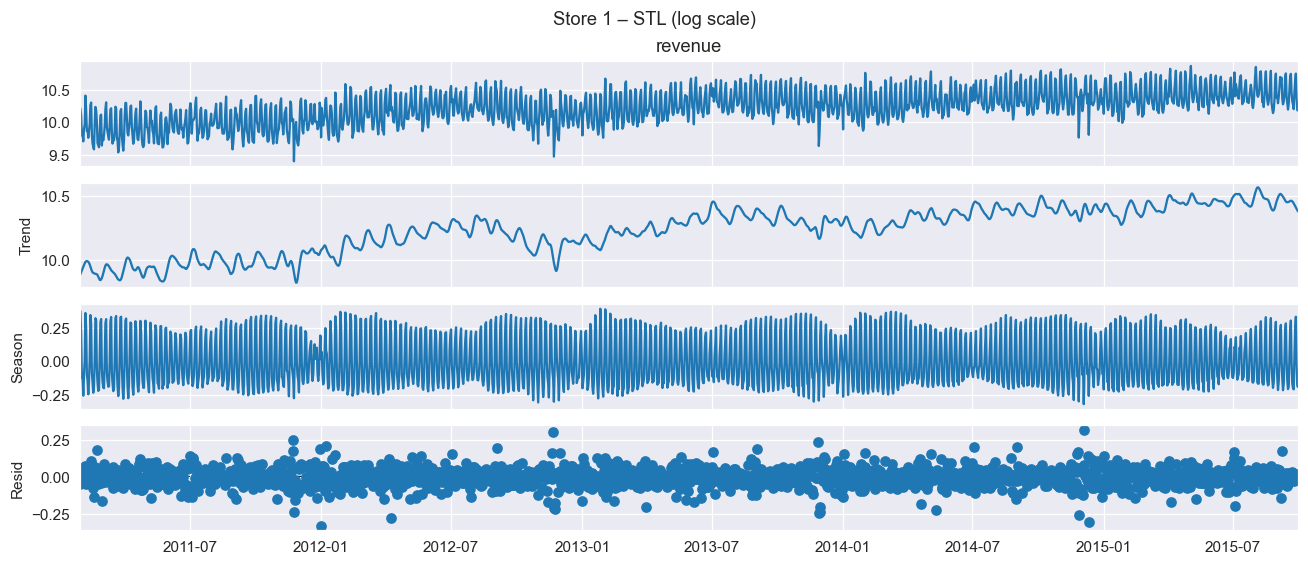

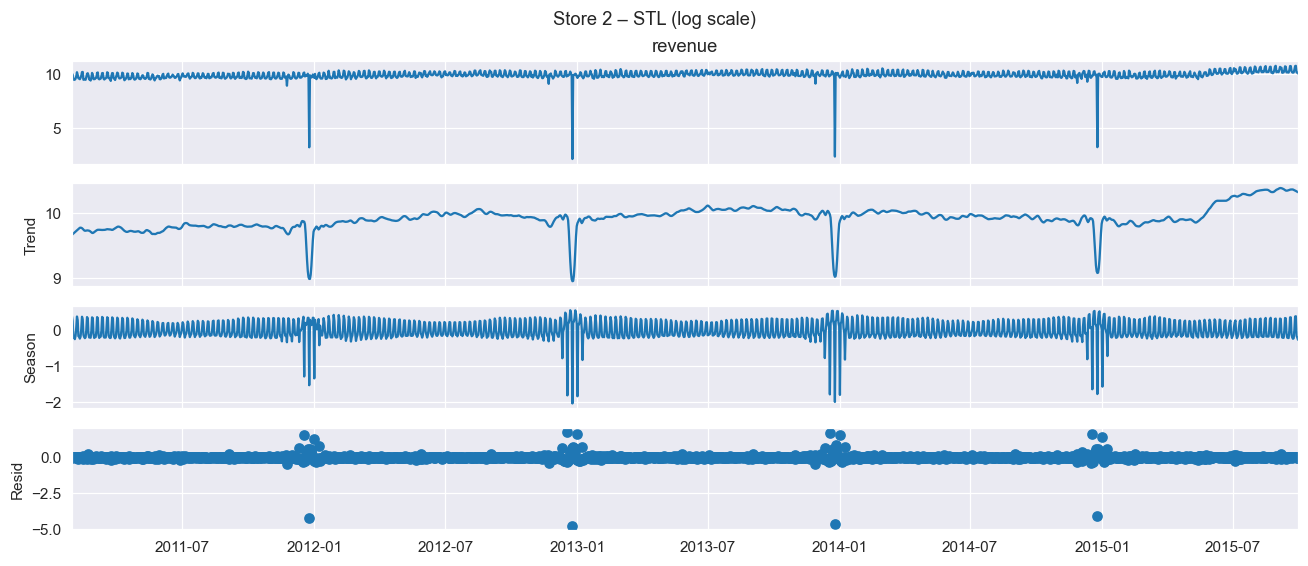

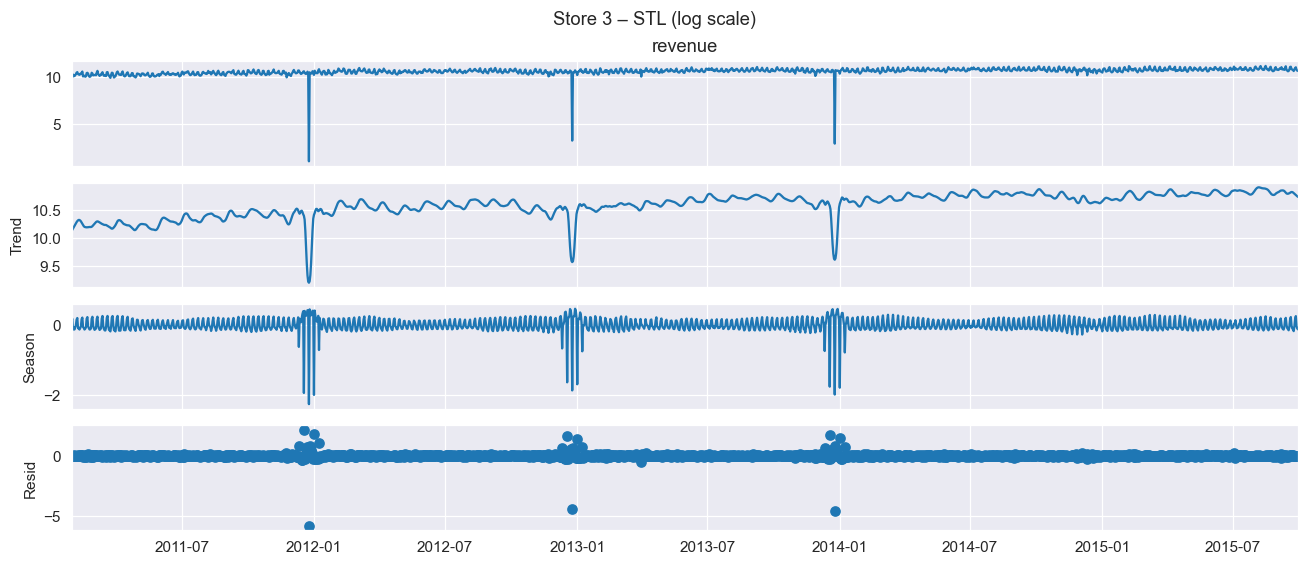

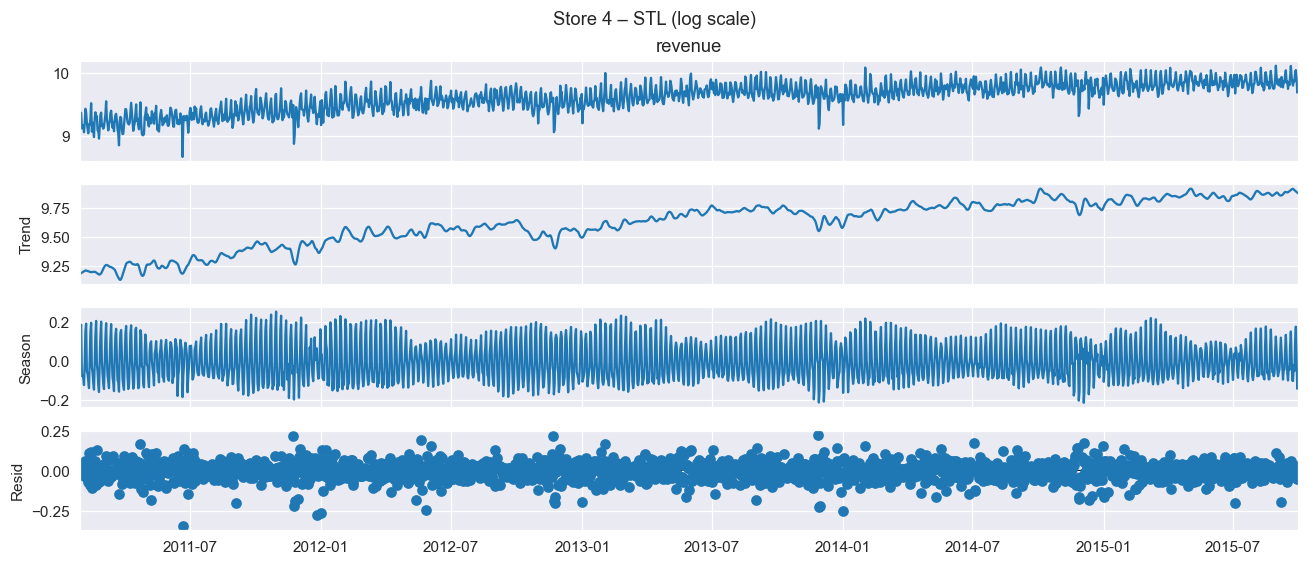

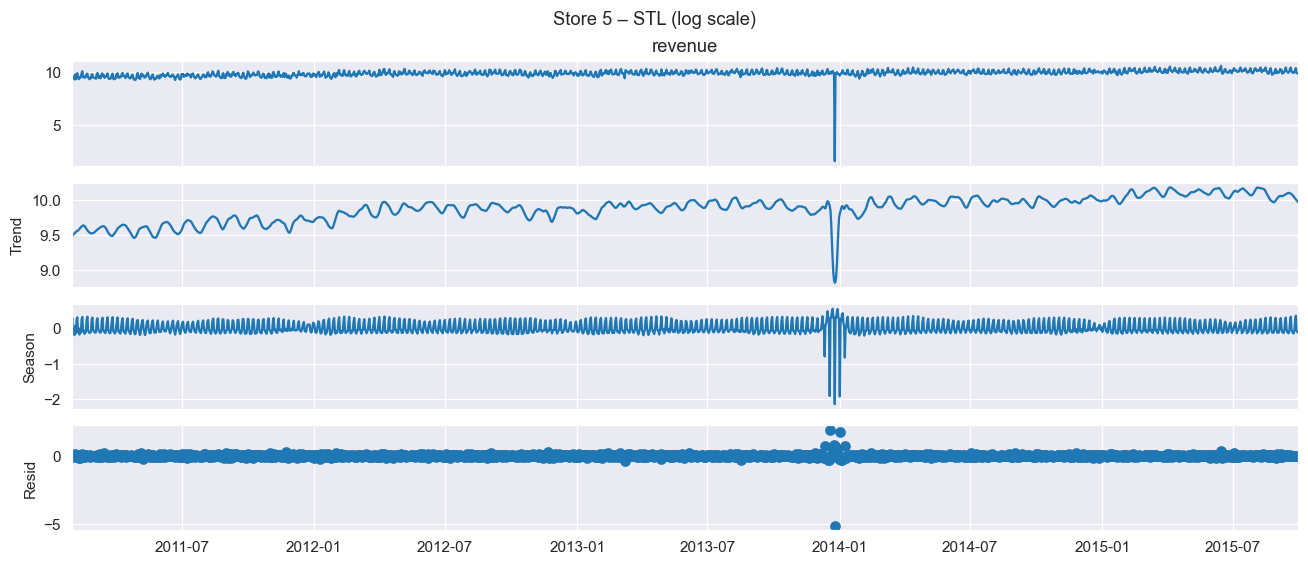

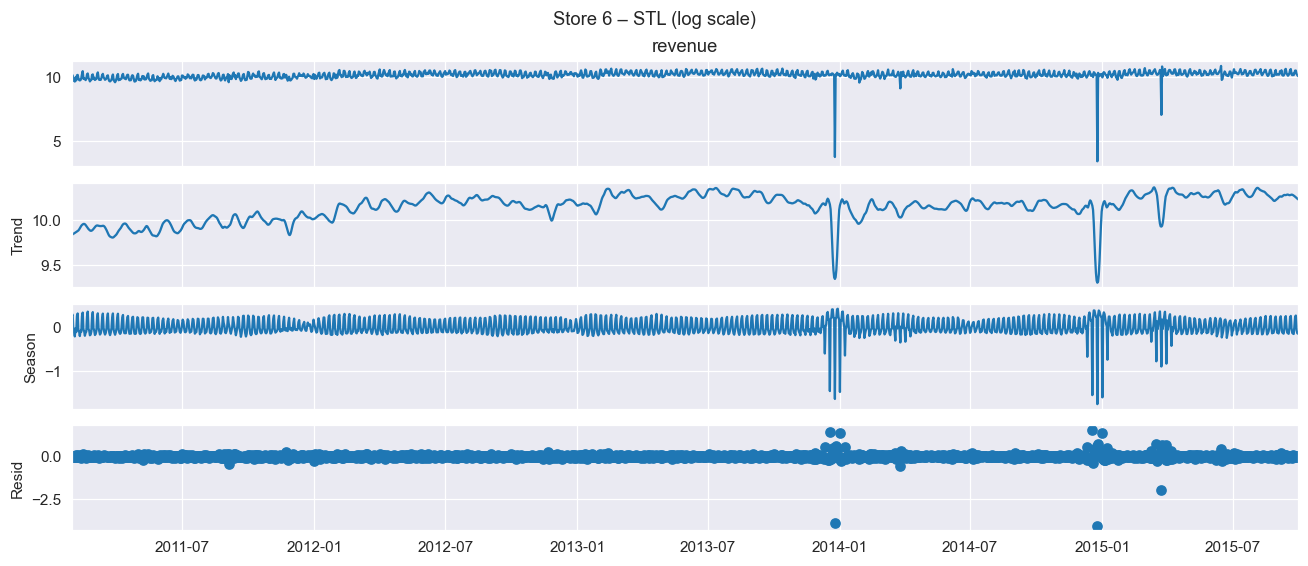

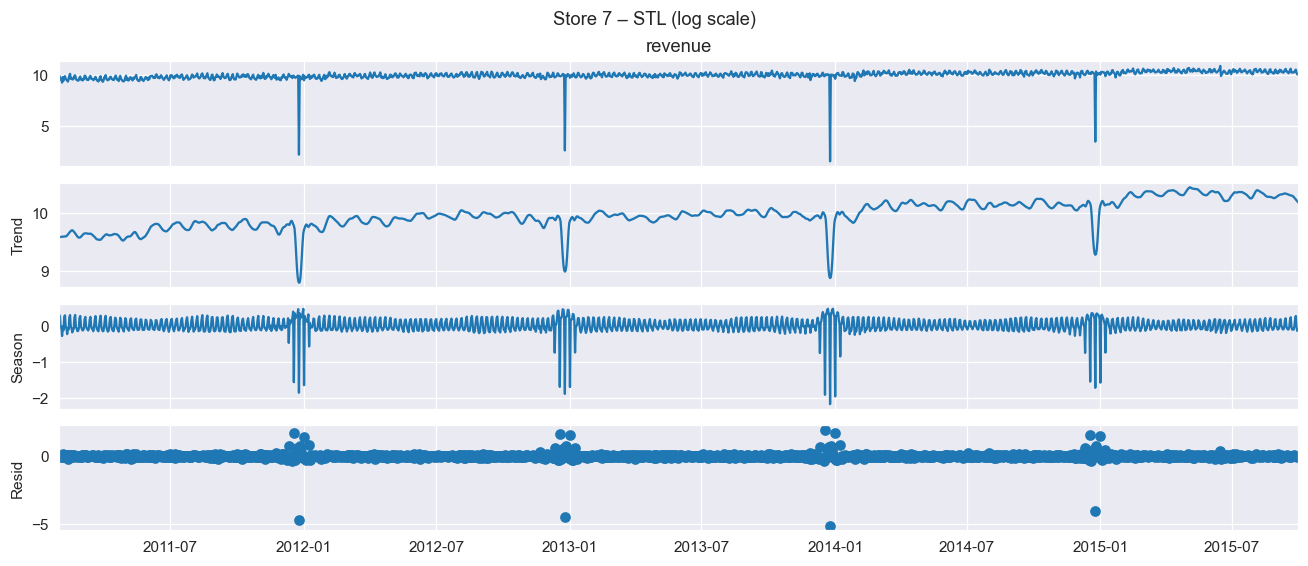

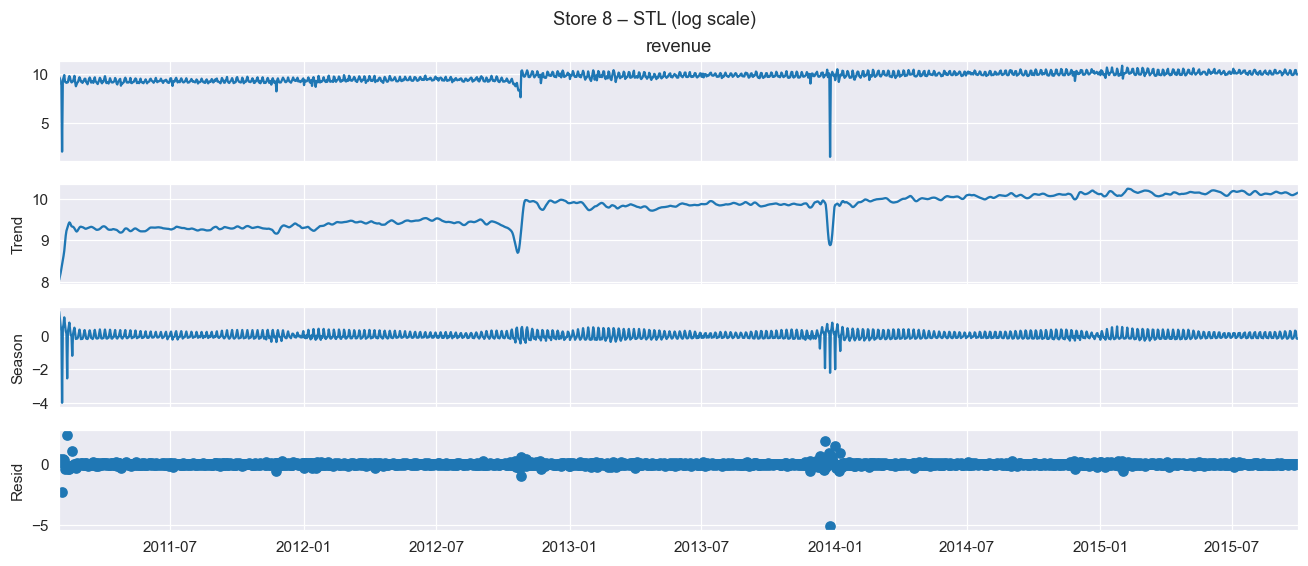

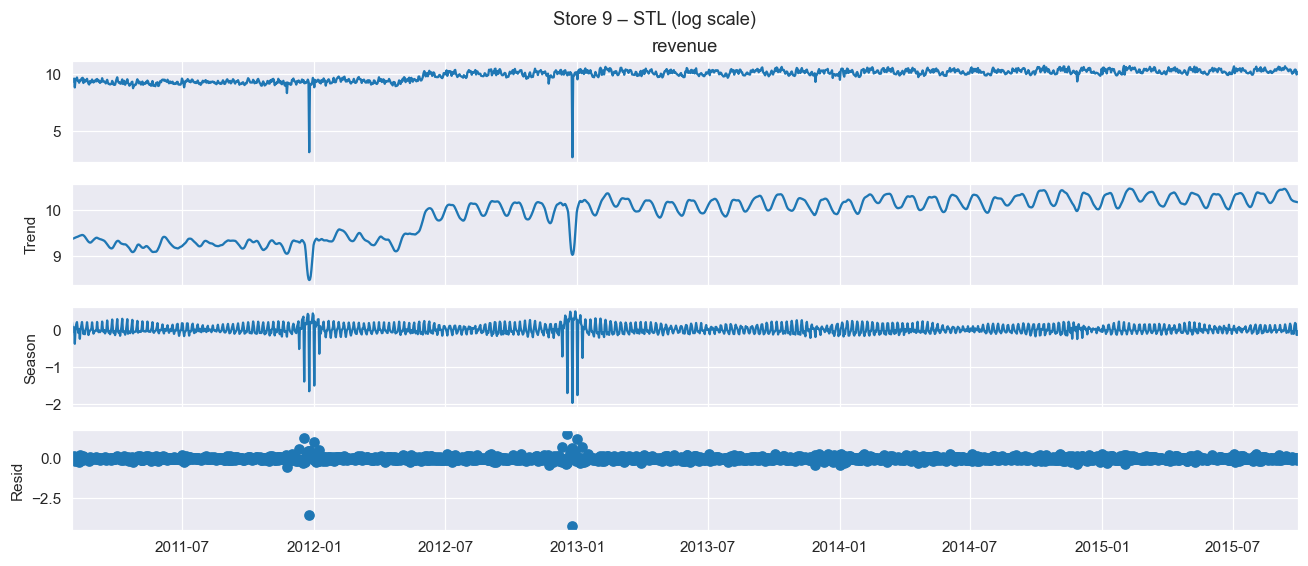

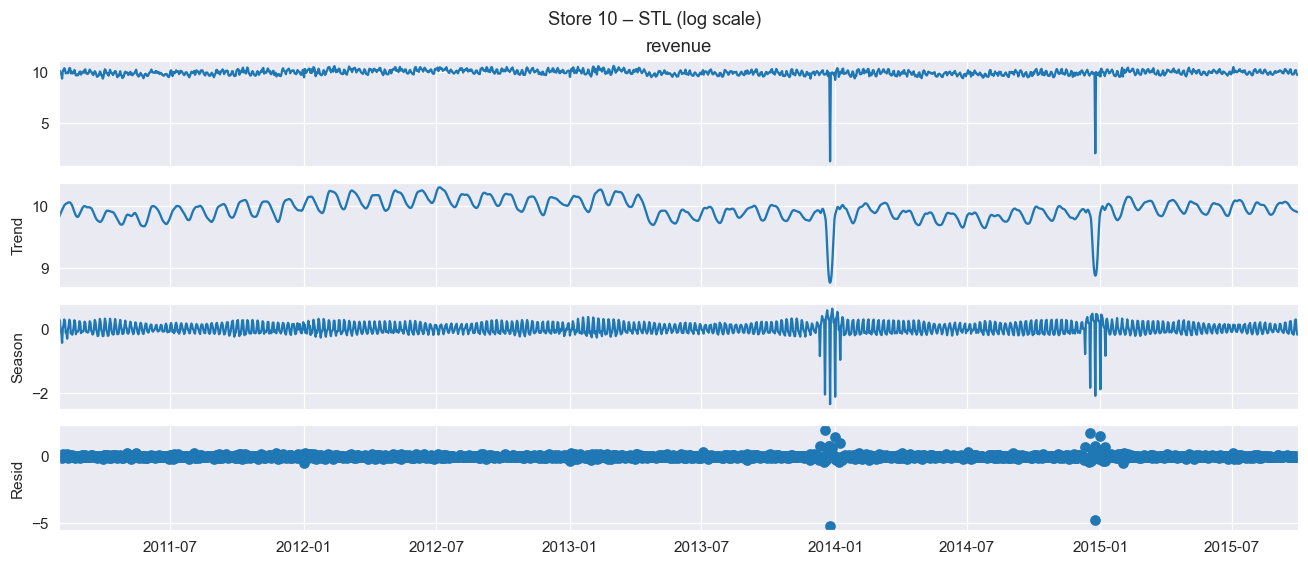

In [25]:
# ------------------------------------------------------------------
# STL decomposition (weekly seasonality)
# ------------------------------------------------------------------
def stl_decomp_plot(store_id, seasonal_len=7):
    series = (
        full_df.query("store_id == @store_id and revenue > 0")
               .set_index("date").revenue
               .pipe(np.log1p)
    )
    stl = STL(series, period=seasonal_len).fit()
    stl.plot()
    plt.suptitle(f"Store {store_id} – STL (log scale)", y=1.02)
    plt.show()
    return stl

# Run for all store IDs in one line
stl_models = {sid: stl_decomp_plot(sid) for sid in sorted(full_df.store_id.unique())}

#### Stationarity tests on STL residuals

- ADF-p < 0.05  → rejects unit-root (non-stationary) ⇒ *stationary*.
- KPSS-p > 0.05 → fails to reject that "Series is stationary around a constant mean" ⇒ cannot prove *non-stationary* ⇒ *stationary*.

**Conclusion:**

After removing trend + weekly seasonality with STL, the residuals of every store are stationary.

No additional differencing or detrending is required before fitting ARMA/SARIMA on those residuals, and machine-learning models can treat the deseasonalised, log-scaled series as stable noise.

In [26]:
# ------------------------------------------------------------------
# Stationarity tests on STL residuals
# ------------------------------------------------------------------

print("ADF & KPSS p-values for STL residuals  (expect ADF<0.05 & KPSS>0.05)")
for sid, stl_obj in stl_models.items():                 # stl_models came from the STL loop
    resid   = stl_obj.resid.dropna()
    adf_p   = adfuller(resid, autolag="AIC")[1]
    kpss_p  = kpss(resid, regression="c", nlags="auto")[1]
    print(f"store {sid:2d}  ADF p={adf_p:.2e}   KPSS p={kpss_p:.3f}")

ADF & KPSS p-values for STL residuals  (expect ADF<0.05 & KPSS>0.05)
store  0  ADF p=8.39e-30   KPSS p=0.100
store  1  ADF p=7.81e-29   KPSS p=0.100
store  2  ADF p=3.09e-30   KPSS p=0.100
store  3  ADF p=9.24e-30   KPSS p=0.100
store  4  ADF p=3.35e-29   KPSS p=0.100
store  5  ADF p=1.49e-29   KPSS p=0.100
store  6  ADF p=4.58e-30   KPSS p=0.100
store  7  ADF p=7.90e-30   KPSS p=0.100
store  8  ADF p=1.59e-28   KPSS p=0.100
store  9  ADF p=5.41e-30   KPSS p=0.100
store 10  ADF p=5.64e-30   KPSS p=0.100


#### Lag-28 PACF check
**Goal:** see whether a 28-day (4-week) memory spike exists. In retail datasets this often shows up because many promotions, payroll cycles, and inventory orders repeat every four weeks.

**Conclusion:**
1. No compelling evidence to require lag_28 as a core feature.
    - For ML models it’s cheap to include and may add a sliver of signal—feel free to add it with low priority.
    - For statistical baselines (SARIMA/ETS) stick with the weekly seasonality only.

<Figure size 880x330 with 0 Axes>

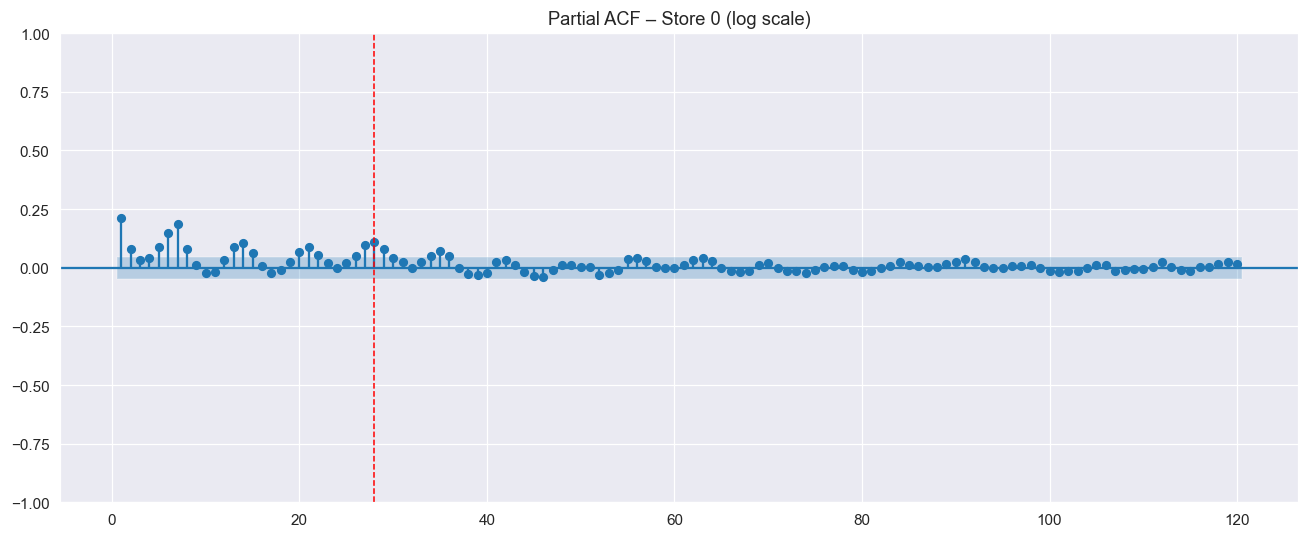

In [27]:
# use the aggregate series so the spike is visible even if it’s faint in one store
series_0 = (
    full_df.query("store_id == 0")
           .set_index("date").revenue
           .pipe(np.log1p)
)

plt.figure(figsize=(8,3))
plot_pacf(series_0, lags=120, zero=False, alpha=0.05)  # show first 120 lags
plt.axvline(28, color="red", ls="--", lw=1)            # highlight lag-28
plt.title("Partial ACF – Store 0 (log scale)")
plt.tight_layout()
plt.show()

In [28]:
full_df.head(10)

,store_id,store_name,date,revenue,event,dow,month,is_zero_day,event_lead1,event_lag1,event_lead2,event_lag2,event_lead3,event_lag3
0,0,All Stores,2011-01-29,204126.52,NaN,5,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,All Stores,2011-01-30,197426.42,NaN,6,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,All Stores,2011-01-31,144267.27,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,All Stores,2011-02-01,151903.00,NaN,1,2,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,All Stores,2011-02-02,117399.88,NaN,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN
5,0,All Stores,2011-02-03,173443.45,NaN,3,2,0,NaN,NaN,NaN,NaN,NaN,NaN
6,0,All Stores,2011-02-04,171972.65,NaN,4,2,0,NaN,NaN,NaN,NaN,NaN,NaN
7,0,All Stores,2011-02-05,233619.38,NaN,5,2,0,NaN,NaN,NaN,NaN,NaN,NaN
8,0,All Stores,2011-02-06,208743.90,SuperBowl,6,2,0,ValentinesDay,None,PresidentsDay,None,LentStart,None
9,0,All Stores,2011-02-07,162911.75,NaN,0,2,0,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# to see the Index of column names
print(full_df.columns)

Index(['store_id', 'store_name', 'date', 'revenue', 'event', 'dow', 'month',
       'is_zero_day', 'event_lead1', 'event_lag1', 'event_lead2', 'event_lag2',
       'event_lead3', 'event_lag3'],
      dtype='object')


In [31]:
# 1. Identify which columns are “features” vs. identifier/target columns
non_features = ['store_id','store_name','date','revenue']
feature_cols = [c for c in full_df.columns if c not in non_features]

print("Feature columns:", feature_cols)
# Feature columns: ['dow','month','is_zero_day',
#                   'event','event_lead1','event_lag1', … ]

# 2. Extract X and y
X = full_df[feature_cols]
y = full_df['revenue']

# 3. Quick sanity‐check
print(X.shape, y.shape)
print(X.head())
print(y.head())


Feature columns: ['event', 'dow', 'month', 'is_zero_day', 'event_lead1', 'event_lag1', 'event_lead2', 'event_lag2', 'event_lead3', 'event_lag3']
(18766, 10) (18766,)
  event  dow  month  is_zero_day event_lead1 event_lag1 event_lead2  \
0   NaN    5      1            0         NaN        NaN         NaN   
1   NaN    6      1            0         NaN        NaN         NaN   
2   NaN    0      1            0         NaN        NaN         NaN   
3   NaN    1      2            0         NaN        NaN         NaN   
4   NaN    2      2            0         NaN        NaN         NaN   

  event_lag2 event_lead3 event_lag3  
0        NaN         NaN        NaN  
1        NaN         NaN        NaN  
2        NaN         NaN        NaN  
3        NaN         NaN        NaN  
4        NaN         NaN        NaN  
0    204126.52
1    197426.42
2    144267.27
3    151903.00
4    117399.88
Name: revenue, dtype: float64


In [47]:
full_df[feature_cols].isnull().sum()


event          17259
dow                0
month              0
is_zero_day        0
event_lead1    17259
event_lag1     17270
event_lead2    17259
event_lag2     17281
event_lead3    17259
event_lag3     17292
dtype: int64

In [34]:
full_df[ full_df['event'].notna() ]

,store_id,store_name,date,revenue,event,dow,month,is_zero_day,event_lead1,event_lag1,event_lead2,event_lag2,event_lead3,event_lag3
8,0,All Stores,2011-02-06,208743.90,SuperBowl,6,2,0,ValentinesDay,None,PresidentsDay,None,LentStart,None
16,0,All Stores,2011-02-14,149322.23,ValentinesDay,0,2,0,PresidentsDay,SuperBowl,LentStart,None,LentWeek2,None
23,0,All Stores,2011-02-21,163868.92,PresidentsDay,0,2,0,LentStart,ValentinesDay,LentWeek2,SuperBowl,StPatricksDay,None
39,0,All Stores,2011-03-09,146929.55,LentStart,2,3,0,LentWeek2,PresidentsDay,StPatricksDay,ValentinesDay,Purim End,SuperBowl
46,0,All Stores,2011-03-16,150190.83,LentWeek2,2,3,0,StPatricksDay,LentStart,Purim End,PresidentsDay,"OrthodoxEaster, Easter",ValentinesDay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18664,10,Wisconsin – Badger Crossing,2015-06-21,21180.60,Father's day,6,6,0,IndependenceDay,Ramadan starts,Eid al-Fitr,NBAFinalsEnd,LaborDay,NBAFinalsStart
18677,10,Wisconsin – Badger Crossing,2015-07-04,20598.22,IndependenceDay,5,7,0,Eid al-Fitr,Father's day,LaborDay,Ramadan starts,EidAlAdha,NBAFinalsEnd
18691,10,Wisconsin – Badger Crossing,2015-07-18,23972.92,Eid al-Fitr,5,7,0,LaborDay,IndependenceDay,EidAlAdha,Father's day,ColumbusDay,Ramadan starts
18742,10,Wisconsin – Badger Crossing,2015-09-07,24211.38,LaborDay,0,9,0,EidAlAdha,Eid al-Fitr,ColumbusDay,IndependenceDay,Halloween,Father's day


In [67]:
# Example: simple label‐encode ‘event’; leave dummies for numeric dow/month
le = LabelEncoder()
full_df['event_le'] = le.fit_transform(full_df['event'].fillna('NoEvent'))

# drop or keep original as you prefer
# full_df.drop('event', axis=1, inplace=True)
feature_cols = [c for c in feature_cols if c!='event'] + ['event_le']

# instead of above, use 1 hot vectore if desirecd

# full_df = pd.get_dummies(full_df, columns=['event'], dummy_na=False)


In [65]:
lag_cols = [f"event_lead{i}" for i in range(1,4)] + [f"event_lag{i}" for i in range(1,4)]

for col in lag_cols:
    # fill NaNs with a “NoEvent” sentinel (so they get their own code)
    full_df[col] = full_df[col].fillna("NoEvent")
    le_events_lead_lag = LabelEncoder()
    full_df[col+"_le"] = le_events_lead_lag.fit_transform(full_df[col])

# drop the old string columns
full_df.drop(columns=lag_cols, inplace=True)

# update your feature list
feature_cols = [c for c in feature_cols if c not in lag_cols] + [col+"_le" for col in lag_cols]


KeyError: 'event_lead1'

In [68]:
full_df.head()

,store_id,store_name,date,revenue,event,dow,month,is_zero_day,event_le,event_lead1_le,event_lead2_le,event_lead3_le,event_lag1_le,event_lag2_le,event_lag3_le
0,0,All Stores,2011-01-29,204126.52,NaN,5,1,0,21,21,21,21,21,21,21
1,0,All Stores,2011-01-30,197426.42,NaN,6,1,0,21,21,21,21,21,21,21
2,0,All Stores,2011-01-31,144267.27,NaN,0,1,0,21,21,21,21,21,21,21
3,0,All Stores,2011-02-01,151903.00,NaN,1,2,0,21,21,21,21,21,21,21
4,0,All Stores,2011-02-02,117399.88,NaN,2,2,0,21,21,21,21,21,21,21


## Train - Test split

In [61]:
# # 3. Time‐based train/validation split
# # ensure ‘date’ is datetime
# full_df['date'] = pd.to_datetime(full_df['date'])
#
# # choose a split date, e.g. last 28 days for validation
# split_date = full_df['date'].max() - pd.Timedelta(days=28)
#
# train_df = full_df[full_df['date'] < split_date].copy()
# val_df   = full_df[full_df['date'] >= split_date].copy()
#
# X_train, y_train = train_df[feature_cols], train_df['revenue']
# X_val,   y_val   = val_df[feature_cols],   val_df['revenue']
#
# print("Train:", X_train.shape, "Validation:", X_val.shape)


Train: (18447, 11) Validation: (319, 11)


In [71]:
# 1. Ensure date is datetime
full_df['date'] = pd.to_datetime(full_df['date'])

# 2. Define window sizes
val_days  = 28   # e.g. use last 28 days for validation
test_days = 28   # e.g. use final 28 days for test

# 3. Compute cut-off dates
max_date    = full_df['date'].max()
test_start  = max_date - pd.Timedelta(days=test_days - 1)
val_start   = test_start - pd.Timedelta(days=val_days)

# 4. Split
train_df = full_df[ full_df['date'] <     val_start ]
val_df   = full_df[(full_df['date'] >=    val_start) &
                   (full_df['date'] <    test_start)]
test_df  = full_df[ full_df['date'] >=    test_start ]

# 5. Extract X/y
non_features = ['store_id','store_name','date','revenue','event']
feature_cols = [c for c in full_df.columns if c not in non_features]

X_train, y_train = train_df[feature_cols], train_df['revenue']
X_val,   y_val   = val_df[feature_cols],   val_df['revenue']
X_test,  y_test  = test_df[feature_cols],  test_df['revenue']

# 6. Sanity check shapes & date ranges
print("Train:", train_df['date'].min(), "→", train_df['date'].max(), X_train.shape)
print("Val:  ", val_df['date'].min(),   "→", val_df['date'].max(),   X_val.shape)
print("Test: ", test_df['date'].min(),  "→", test_df['date'].max(),  X_test.shape)

Train: 2011-01-29 00:00:00 → 2015-08-05 00:00:00 (18150, 10)
Val:   2015-08-06 00:00:00 → 2015-09-02 00:00:00 (308, 10)
Test:  2015-09-03 00:00:00 → 2015-09-30 00:00:00 (308, 10)


In [79]:
## 4. Fit a LightGBM baseline

train_data = lgb.Dataset(X_train, label=y_train)
val_data   = lgb.Dataset(X_val,   label=y_val, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

bst = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

# quick validation RMSE
y_pred = bst.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
test_rmse = root_mean_squared_error(y_test, bst.predict(X_test))
print(f"Validation RMSE: {rmse:.4f}")
print(f'Test RMSE: {test_rmse:.4f}')



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 18150, number of used features: 10
[LightGBM] [Info] Start training from score 42723.078822
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 63192.1	valid_1's rmse: 79233.8
[100]	training's rmse: 63180.3	valid_1's rmse: 79206.1
Early stopping, best iteration is:
[74]	training's rmse: 63181.1	valid_1's rmse: 79186.1
Validation RMSE: 79186.1202
Test RMSE: 79489.1775


In [80]:
# 2) Define the Optuna objective
def objective(trial):
    # Suggest hyper-parameters
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'seed': 42
    }

    # Create datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data   = lgb.Dataset(X_val,   label=y_val, reference=train_data)

    # Train with early stopping
    gbm = lgb.train(
        param,
        train_data,
        num_boost_round=1000,
        valid_sets=[val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0)  # silent
        ]
    )

    # Predict & evaluate on validation set
    preds = gbm.predict(X_val)
    return root_mean_squared_error(y_val, preds)

# 3) Run the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print(f"Best validation RMSE: {study.best_value:.4f}")

# 4) (Optional) Train final model on train+val, test on hold-out
best_params = study.best_params.copy()
best_params.update({'objective':'regression','metric':'rmse','verbosity':-1})

# Combine train+val
train_val_df = pd.concat([train_df, val_df])
train_val_data = lgb.Dataset(train_val_df[feature_cols], label=train_val_df['revenue'])

final_gbm = lgb.train(
    best_params,
    train_val_data,
    num_boost_round=study.best_trial.number  # or fixed rounds
)

y_test_pred = final_gbm.predict(X_test)
print(f"Test RMSE: {root_mean_squared_error(y_test, y_test_pred):.4f}")


[I 2025-06-09 13:48:09,968] A new study created in memory with name: no-name-20179638-a900-42ec-8f10-565d75b91a5b


Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:13,548] Trial 0 finished with value: 79300.13825616888 and parameters: {'learning_rate': 0.003782047390013068, 'num_leaves': 60, 'max_depth': 11, 'feature_fraction': 0.7188515793594181, 'bagging_fraction': 0.7651801897818584, 'bagging_freq': 9, 'min_data_in_leaf': 44, 'lambda_l1': 4.592253118371728, 'lambda_l2': 1.5103761335920374}. Best is trial 0 with value: 79300.13825616888.


Early stopping, best iteration is:
[603]	valid_0's rmse: 79300.1
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:14,298] Trial 1 finished with value: 79271.44592647397 and parameters: {'learning_rate': 0.011987903181025019, 'num_leaves': 123, 'max_depth': 5, 'feature_fraction': 0.5760083200337278, 'bagging_fraction': 0.7196271390130453, 'bagging_freq': 9, 'min_data_in_leaf': 58, 'lambda_l1': 1.2415476133411407, 'lambda_l2': 3.6893439020364354}. Best is trial 1 with value: 79271.44592647397.


Early stopping, best iteration is:
[298]	valid_0's rmse: 79271.4
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:15,645] Trial 2 finished with value: 79247.96503667736 and parameters: {'learning_rate': 0.006633614757044063, 'num_leaves': 40, 'max_depth': 8, 'feature_fraction': 0.9351199469868516, 'bagging_fraction': 0.5552973286654239, 'bagging_freq': 3, 'min_data_in_leaf': 38, 'lambda_l1': 3.1455943627504035, 'lambda_l2': 3.0967209558090087}. Best is trial 2 with value: 79247.96503667736.


Early stopping, best iteration is:
[510]	valid_0's rmse: 79248
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:16,313] Trial 3 finished with value: 79297.40401174902 and parameters: {'learning_rate': 0.006141165670131568, 'num_leaves': 109, 'max_depth': 9, 'feature_fraction': 0.845992931116071, 'bagging_fraction': 0.5617445461250383, 'bagging_freq': 10, 'min_data_in_leaf': 47, 'lambda_l1': 3.57864791862891, 'lambda_l2': 2.071502840392993}. Best is trial 2 with value: 79247.96503667736.


Early stopping, best iteration is:
[211]	valid_0's rmse: 79297.4
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:16,497] Trial 4 finished with value: 79223.00220312373 and parameters: {'learning_rate': 0.04740122670530446, 'num_leaves': 89, 'max_depth': 6, 'feature_fraction': 0.9900214222798259, 'bagging_fraction': 0.510644710329212, 'bagging_freq': 5, 'min_data_in_leaf': 72, 'lambda_l1': 4.210499187063518, 'lambda_l2': 3.298072097729463}. Best is trial 4 with value: 79223.00220312373.


Early stopping, best iteration is:
[45]	valid_0's rmse: 79223
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:18,066] Trial 5 finished with value: 79252.25175098995 and parameters: {'learning_rate': 0.004220276550186079, 'num_leaves': 44, 'max_depth': 6, 'feature_fraction': 0.8318585670131498, 'bagging_fraction': 0.6633093243454654, 'bagging_freq': 3, 'min_data_in_leaf': 83, 'lambda_l1': 4.829403233870925, 'lambda_l2': 3.7439496798889635}. Best is trial 4 with value: 79223.00220312373.


Early stopping, best iteration is:
[654]	valid_0's rmse: 79252.3
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:18,924] Trial 6 finished with value: 79247.31094465478 and parameters: {'learning_rate': 0.007985773175470933, 'num_leaves': 42, 'max_depth': 5, 'feature_fraction': 0.7032890598567895, 'bagging_fraction': 0.8627849011779002, 'bagging_freq': 8, 'min_data_in_leaf': 87, 'lambda_l1': 2.0774435597015035, 'lambda_l2': 4.988644652465776}. Best is trial 4 with value: 79223.00220312373.


Early stopping, best iteration is:
[536]	valid_0's rmse: 79247.3
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:19,243] Trial 7 finished with value: 79261.38555479952 and parameters: {'learning_rate': 0.023745420075749025, 'num_leaves': 103, 'max_depth': 3, 'feature_fraction': 0.8823927847910672, 'bagging_fraction': 0.7290805638888712, 'bagging_freq': 9, 'min_data_in_leaf': 74, 'lambda_l1': 3.7082196648691443, 'lambda_l2': 2.114128053793513}. Best is trial 4 with value: 79223.00220312373.


Early stopping, best iteration is:
[198]	valid_0's rmse: 79261.4
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:19,952] Trial 8 finished with value: 79246.08624403017 and parameters: {'learning_rate': 0.01523573858821551, 'num_leaves': 101, 'max_depth': 7, 'feature_fraction': 0.8806742809655004, 'bagging_fraction': 0.7395051946295402, 'bagging_freq': 8, 'min_data_in_leaf': 24, 'lambda_l1': 1.7118816412515836, 'lambda_l2': 4.944524825266563}. Best is trial 4 with value: 79223.00220312373.


Early stopping, best iteration is:
[264]	valid_0's rmse: 79246.1
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:21,784] Trial 9 finished with value: 79240.9221069123 and parameters: {'learning_rate': 0.005816969341635777, 'num_leaves': 66, 'max_depth': 9, 'feature_fraction': 0.6678254024382263, 'bagging_fraction': 0.9633808050571475, 'bagging_freq': 10, 'min_data_in_leaf': 32, 'lambda_l1': 3.3263534299812205, 'lambda_l2': 2.7890287546011687}. Best is trial 4 with value: 79223.00220312373.


Early stopping, best iteration is:
[633]	valid_0's rmse: 79240.9
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:22,273] Trial 10 finished with value: 79124.89641442298 and parameters: {'learning_rate': 0.09022602306858304, 'num_leaves': 86, 'max_depth': 12, 'feature_fraction': 0.9869626945653123, 'bagging_fraction': 0.5111819223534926, 'bagging_freq': 5, 'min_data_in_leaf': 99, 'lambda_l1': 0.5806208335496845, 'lambda_l2': 0.07090131455455406}. Best is trial 10 with value: 79124.89641442298.


Early stopping, best iteration is:
[25]	valid_0's rmse: 79124.9
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:22,834] Trial 11 finished with value: 79138.89653332521 and parameters: {'learning_rate': 0.07589760743031392, 'num_leaves': 88, 'max_depth': 12, 'feature_fraction': 0.9830012699962135, 'bagging_fraction': 0.5045659833351168, 'bagging_freq': 5, 'min_data_in_leaf': 98, 'lambda_l1': 0.29373109952043075, 'lambda_l2': 0.07018302669760601}. Best is trial 10 with value: 79124.89641442298.


Early stopping, best iteration is:
[50]	valid_0's rmse: 79138.9
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:23,299] Trial 12 finished with value: 79124.09879148152 and parameters: {'learning_rate': 0.08647521266775052, 'num_leaves': 16, 'max_depth': 12, 'feature_fraction': 0.9963536950181178, 'bagging_fraction': 0.6169632049066298, 'bagging_freq': 5, 'min_data_in_leaf': 100, 'lambda_l1': 0.09212385562924791, 'lambda_l2': 0.0688975760738352}. Best is trial 12 with value: 79124.09879148152.


Early stopping, best iteration is:
[74]	valid_0's rmse: 79124.1
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:25,525] Trial 13 finished with value: 79370.24953725305 and parameters: {'learning_rate': 0.0011700445099946562, 'num_leaves': 21, 'max_depth': 11, 'feature_fraction': 0.7973801107346666, 'bagging_fraction': 0.6316732307442218, 'bagging_freq': 1, 'min_data_in_leaf': 100, 'lambda_l1': 0.015183816488705162, 'lambda_l2': 0.07873132264559445}. Best is trial 12 with value: 79124.09879148152.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 79370.2
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:26,119] Trial 14 finished with value: 79122.31090433759 and parameters: {'learning_rate': 0.07764805171988931, 'num_leaves': 23, 'max_depth': 12, 'feature_fraction': 0.9273588204975669, 'bagging_fraction': 0.6012332069760846, 'bagging_freq': 6, 'min_data_in_leaf': 90, 'lambda_l1': 0.9078146744623865, 'lambda_l2': 0.8201404795187566}. Best is trial 14 with value: 79122.31090433759.


Early stopping, best iteration is:
[126]	valid_0's rmse: 79122.3
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:26,642] Trial 15 finished with value: 79133.22596582041 and parameters: {'learning_rate': 0.0384286191662491, 'num_leaves': 18, 'max_depth': 10, 'feature_fraction': 0.9169962916472002, 'bagging_fraction': 0.6418300437021105, 'bagging_freq': 7, 'min_data_in_leaf': 88, 'lambda_l1': 0.9505522017007562, 'lambda_l2': 0.9862019118845353}. Best is trial 14 with value: 79122.31090433759.


Early stopping, best iteration is:
[105]	valid_0's rmse: 79133.2
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:27,226] Trial 16 finished with value: 79173.4028884931 and parameters: {'learning_rate': 0.044650434199279276, 'num_leaves': 23, 'max_depth': 10, 'feature_fraction': 0.5219823316775315, 'bagging_fraction': 0.6005863290633616, 'bagging_freq': 6, 'min_data_in_leaf': 66, 'lambda_l1': 2.611972226758099, 'lambda_l2': 0.8366878875186763}. Best is trial 14 with value: 79122.31090433759.


Early stopping, best iteration is:
[126]	valid_0's rmse: 79173.4
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:28,058] Trial 17 finished with value: 79221.82052832097 and parameters: {'learning_rate': 0.02356200478176553, 'num_leaves': 53, 'max_depth': 12, 'feature_fraction': 0.7791799690066614, 'bagging_fraction': 0.6698811449749862, 'bagging_freq': 3, 'min_data_in_leaf': 79, 'lambda_l1': 1.258583732732971, 'lambda_l2': 0.7988303118167821}. Best is trial 14 with value: 79122.31090433759.


Early stopping, best iteration is:
[150]	valid_0's rmse: 79221.8
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:28,633] Trial 18 finished with value: 79143.86118758561 and parameters: {'learning_rate': 0.09879727754336441, 'num_leaves': 31, 'max_depth': 11, 'feature_fraction': 0.9292922918204192, 'bagging_fraction': 0.8161673939406802, 'bagging_freq': 4, 'min_data_in_leaf': 91, 'lambda_l1': 0.6684677177154057, 'lambda_l2': 1.2510633762218113}. Best is trial 14 with value: 79122.31090433759.


Early stopping, best iteration is:
[76]	valid_0's rmse: 79143.9
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:29,598] Trial 19 finished with value: 79180.73939678827 and parameters: {'learning_rate': 0.059906243948550854, 'num_leaves': 16, 'max_depth': 10, 'feature_fraction': 0.9424961373693823, 'bagging_fraction': 0.5996942839508137, 'bagging_freq': 6, 'min_data_in_leaf': 57, 'lambda_l1': 1.9973086061922094, 'lambda_l2': 0.5311812299543771}. Best is trial 14 with value: 79122.31090433759.


Early stopping, best iteration is:
[54]	valid_0's rmse: 79180.7
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:30,322] Trial 20 finished with value: 79226.41797995991 and parameters: {'learning_rate': 0.026054754411532342, 'num_leaves': 31, 'max_depth': 8, 'feature_fraction': 0.6214186453020788, 'bagging_fraction': 0.6890287796823045, 'bagging_freq': 1, 'min_data_in_leaf': 92, 'lambda_l1': 0.057692452728626, 'lambda_l2': 1.6396771083072172}. Best is trial 14 with value: 79122.31090433759.


Early stopping, best iteration is:
[158]	valid_0's rmse: 79226.4
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:30,903] Trial 21 finished with value: 79091.35551166555 and parameters: {'learning_rate': 0.09613997616146125, 'num_leaves': 79, 'max_depth': 12, 'feature_fraction': 0.9934560081228001, 'bagging_fraction': 0.5631913560368501, 'bagging_freq': 4, 'min_data_in_leaf': 98, 'lambda_l1': 0.5443427683981072, 'lambda_l2': 0.41371156145807575}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[40]	valid_0's rmse: 79091.4
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:31,721] Trial 22 finished with value: 79170.84461323879 and parameters: {'learning_rate': 0.06570354585112384, 'num_leaves': 78, 'max_depth': 12, 'feature_fraction': 0.991485270786153, 'bagging_fraction': 0.5725931611423699, 'bagging_freq': 4, 'min_data_in_leaf': 94, 'lambda_l1': 0.6613788423023992, 'lambda_l2': 0.5407586237301689}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[40]	valid_0's rmse: 79170.8
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:33,318] Trial 23 finished with value: 79147.19514367968 and parameters: {'learning_rate': 0.034316160993281775, 'num_leaves': 72, 'max_depth': 11, 'feature_fraction': 0.888242896879403, 'bagging_fraction': 0.6158706148725015, 'bagging_freq': 7, 'min_data_in_leaf': 80, 'lambda_l1': 1.4502255335619783, 'lambda_l2': 0.4800541544989195}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[147]	valid_0's rmse: 79147.2
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:34,072] Trial 24 finished with value: 79168.30382613829 and parameters: {'learning_rate': 0.0614243618580409, 'num_leaves': 50, 'max_depth': 12, 'feature_fraction': 0.9505449312621098, 'bagging_fraction': 0.5508891932323972, 'bagging_freq': 4, 'min_data_in_leaf': 84, 'lambda_l1': 0.32915986263167785, 'lambda_l2': 1.2358287108902895}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[84]	valid_0's rmse: 79168.3
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:34,518] Trial 25 finished with value: 79158.94210592637 and parameters: {'learning_rate': 0.09824264161222156, 'num_leaves': 32, 'max_depth': 10, 'feature_fraction': 0.838311661788624, 'bagging_fraction': 0.6863632175362109, 'bagging_freq': 2, 'min_data_in_leaf': 94, 'lambda_l1': 0.9374263469732899, 'lambda_l2': 1.8816214148368224}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[42]	valid_0's rmse: 79158.9
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:35,202] Trial 26 finished with value: 79238.81341770354 and parameters: {'learning_rate': 0.017456636162693186, 'num_leaves': 58, 'max_depth': 9, 'feature_fraction': 0.9527086452279625, 'bagging_fraction': 0.7768661754108377, 'bagging_freq': 6, 'min_data_in_leaf': 74, 'lambda_l1': 2.6070632603461275, 'lambda_l2': 0.4089973240786515}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[126]	valid_0's rmse: 79238.8
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:35,848] Trial 27 finished with value: 79145.17377695441 and parameters: {'learning_rate': 0.05264658263597526, 'num_leaves': 79, 'max_depth': 11, 'feature_fraction': 0.9003920011562616, 'bagging_fraction': 0.5805109156851929, 'bagging_freq': 7, 'min_data_in_leaf': 66, 'lambda_l1': 0.9542455218915924, 'lambda_l2': 1.1465003791789474}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[70]	valid_0's rmse: 79145.2
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:37,633] Trial 28 finished with value: 79382.14830434635 and parameters: {'learning_rate': 0.001116537148090842, 'num_leaves': 27, 'max_depth': 3, 'feature_fraction': 0.9603585109524805, 'bagging_fraction': 0.53739699524374, 'bagging_freq': 4, 'min_data_in_leaf': 96, 'lambda_l1': 1.669460229605419, 'lambda_l2': 2.429646525775701}. Best is trial 21 with value: 79091.35551166555.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 79382.1
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 79271.9


[I 2025-06-09 13:48:41,088] Trial 29 finished with value: 79271.87796443563 and parameters: {'learning_rate': 0.002241823750989988, 'num_leaves': 65, 'max_depth': 11, 'feature_fraction': 0.7338429761284632, 'bagging_fraction': 0.9903643001704566, 'bagging_freq': 5, 'min_data_in_leaf': 88, 'lambda_l1': 0.45094342196607484, 'lambda_l2': 1.5540182091631423}. Best is trial 21 with value: 79091.35551166555.


Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:41,950] Trial 30 finished with value: 79164.93952362012 and parameters: {'learning_rate': 0.03277486388770306, 'num_leaves': 37, 'max_depth': 12, 'feature_fraction': 0.8487000462542159, 'bagging_fraction': 0.6402969894014345, 'bagging_freq': 2, 'min_data_in_leaf': 45, 'lambda_l1': 0.9573571527437232, 'lambda_l2': 0.328621557835269}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[188]	valid_0's rmse: 79164.9
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:42,488] Trial 31 finished with value: 79116.76838211334 and parameters: {'learning_rate': 0.08792181033121052, 'num_leaves': 91, 'max_depth': 12, 'feature_fraction': 0.9894126717474309, 'bagging_fraction': 0.5227924850988703, 'bagging_freq': 5, 'min_data_in_leaf': 96, 'lambda_l1': 0.5716405605933887, 'lambda_l2': 0.06565508876539679}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[50]	valid_0's rmse: 79116.8
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:43,025] Trial 32 finished with value: 79100.3650505925 and parameters: {'learning_rate': 0.07772057289198868, 'num_leaves': 123, 'max_depth': 12, 'feature_fraction': 0.9997219344352941, 'bagging_fraction': 0.5292056664990643, 'bagging_freq': 6, 'min_data_in_leaf': 100, 'lambda_l1': 0.193563753777437, 'lambda_l2': 0.7359521544072015}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[60]	valid_0's rmse: 79100.4
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:43,498] Trial 33 finished with value: 79105.01000259064 and parameters: {'learning_rate': 0.07233892063324777, 'num_leaves': 128, 'max_depth': 11, 'feature_fraction': 0.9136686673087158, 'bagging_fraction': 0.5348555460558737, 'bagging_freq': 6, 'min_data_in_leaf': 91, 'lambda_l1': 1.2172424597475417, 'lambda_l2': 0.7555805645645428}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[60]	valid_0's rmse: 79105
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:44,028] Trial 34 finished with value: 79139.05257896392 and parameters: {'learning_rate': 0.05551535654186018, 'num_leaves': 123, 'max_depth': 11, 'feature_fraction': 0.9752231474256582, 'bagging_fraction': 0.5407659180525595, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'lambda_l1': 1.266261990010627, 'lambda_l2': 1.4076714438050382}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[70]	valid_0's rmse: 79139.1
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:44,658] Trial 35 finished with value: 79141.63500538295 and parameters: {'learning_rate': 0.04289384366707411, 'num_leaves': 128, 'max_depth': 10, 'feature_fraction': 0.9594445741645724, 'bagging_fraction': 0.5297139132411834, 'bagging_freq': 8, 'min_data_in_leaf': 84, 'lambda_l1': 0.3841188023793929, 'lambda_l2': 0.7162132385006684}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[120]	valid_0's rmse: 79141.6
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:45,150] Trial 36 finished with value: 79122.10978458234 and parameters: {'learning_rate': 0.0677723399593769, 'num_leaves': 113, 'max_depth': 11, 'feature_fraction': 0.9998537957262376, 'bagging_fraction': 0.5683678234534881, 'bagging_freq': 6, 'min_data_in_leaf': 80, 'lambda_l1': 2.152103956019826, 'lambda_l2': 4.129657078715014}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[59]	valid_0's rmse: 79122.1
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:45,967] Trial 37 finished with value: 79265.23339913975 and parameters: {'learning_rate': 0.012590215088327745, 'num_leaves': 116, 'max_depth': 8, 'feature_fraction': 0.9090209372732048, 'bagging_fraction': 0.5002420932604273, 'bagging_freq': 3, 'min_data_in_leaf': 95, 'lambda_l1': 0.699107551526118, 'lambda_l2': 0.30533590849526954}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[201]	valid_0's rmse: 79265.2
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:46,618] Trial 38 finished with value: 79249.07792700778 and parameters: {'learning_rate': 0.031695620241667985, 'num_leaves': 103, 'max_depth': 9, 'feature_fraction': 0.8694019372155282, 'bagging_fraction': 0.5295015807525378, 'bagging_freq': 4, 'min_data_in_leaf': 53, 'lambda_l1': 1.449351021452363, 'lambda_l2': 0.9890798848563337}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[84]	valid_0's rmse: 79249.1
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:46,988] Trial 39 finished with value: 79171.90393948404 and parameters: {'learning_rate': 0.046311068352660044, 'num_leaves': 95, 'max_depth': 4, 'feature_fraction': 0.7864818187500334, 'bagging_fraction': 0.5818475792411278, 'bagging_freq': 5, 'min_data_in_leaf': 86, 'lambda_l1': 4.118881081888766, 'lambda_l2': 1.8167571329850847}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[100]	valid_0's rmse: 79171.9
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:48,268] Trial 40 finished with value: 79197.12128593012 and parameters: {'learning_rate': 0.019036359588671323, 'num_leaves': 118, 'max_depth': 11, 'feature_fraction': 0.961939629915742, 'bagging_fraction': 0.5541660014585343, 'bagging_freq': 8, 'min_data_in_leaf': 77, 'lambda_l1': 0.25098252045629893, 'lambda_l2': 0.6251028743288067}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[168]	valid_0's rmse: 79197.1
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:48,911] Trial 41 finished with value: 79112.04207657713 and parameters: {'learning_rate': 0.07344057688917167, 'num_leaves': 111, 'max_depth': 11, 'feature_fraction': 0.9983138765057152, 'bagging_fraction': 0.5679039284965793, 'bagging_freq': 6, 'min_data_in_leaf': 82, 'lambda_l1': 2.1103428135631446, 'lambda_l2': 4.488426472526816}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[59]	valid_0's rmse: 79112
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:49,594] Trial 42 finished with value: 79125.95383947375 and parameters: {'learning_rate': 0.08065805670592141, 'num_leaves': 111, 'max_depth': 12, 'feature_fraction': 0.9425468962743097, 'bagging_fraction': 0.5310393185642163, 'bagging_freq': 6, 'min_data_in_leaf': 68, 'lambda_l1': 2.3499774645506895, 'lambda_l2': 3.877355026729414}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[60]	valid_0's rmse: 79126
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:50,171] Trial 43 finished with value: 79104.06138987288 and parameters: {'learning_rate': 0.06966613046128255, 'num_leaves': 126, 'max_depth': 10, 'feature_fraction': 0.9726302124210477, 'bagging_fraction': 0.5168998773207887, 'bagging_freq': 7, 'min_data_in_leaf': 90, 'lambda_l1': 1.650505009009551, 'lambda_l2': 3.293581154416887}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[35]	valid_0's rmse: 79104.1
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:50,705] Trial 44 finished with value: 79151.61224457156 and parameters: {'learning_rate': 0.06804380906334587, 'num_leaves': 128, 'max_depth': 10, 'feature_fraction': 0.9695865738520784, 'bagging_fraction': 0.8666731103790535, 'bagging_freq': 7, 'min_data_in_leaf': 90, 'lambda_l1': 2.872904026043722, 'lambda_l2': 4.513651463399255}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[35]	valid_0's rmse: 79151.6
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:51,078] Trial 45 finished with value: 79142.96991106111 and parameters: {'learning_rate': 0.05272655051703055, 'num_leaves': 120, 'max_depth': 7, 'feature_fraction': 0.91638777357395, 'bagging_fraction': 0.5590119587101245, 'bagging_freq': 9, 'min_data_in_leaf': 100, 'lambda_l1': 1.8171507763690524, 'lambda_l2': 3.2746519714676445}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[45]	valid_0's rmse: 79143
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:52,033] Trial 46 finished with value: 79284.17609084779 and parameters: {'learning_rate': 0.009749232131092824, 'num_leaves': 109, 'max_depth': 9, 'feature_fraction': 0.8651706692418036, 'bagging_fraction': 0.5008404644908977, 'bagging_freq': 8, 'min_data_in_leaf': 84, 'lambda_l1': 1.493294229352483, 'lambda_l2': 3.4274444369535777}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[168]	valid_0's rmse: 79284.2
Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:52,673] Trial 47 finished with value: 79137.5087587163 and parameters: {'learning_rate': 0.07435243019556322, 'num_leaves': 122, 'max_depth': 11, 'feature_fraction': 0.971268767554142, 'bagging_fraction': 0.574544654884213, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'lambda_l1': 1.9342450010284242, 'lambda_l2': 4.633834114329836}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[35]	valid_0's rmse: 79137.5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[585]	valid_0's rmse: 79299.5


[I 2025-06-09 13:48:56,662] Trial 48 finished with value: 79299.53896091242 and parameters: {'learning_rate': 0.0035904499572945027, 'num_leaves': 104, 'max_depth': 10, 'feature_fraction': 0.8108639381851912, 'bagging_fraction': 0.5933471001600358, 'bagging_freq': 6, 'min_data_in_leaf': 97, 'lambda_l1': 2.1574769587076066, 'lambda_l2': 2.302236333481723}. Best is trial 21 with value: 79091.35551166555.


Training until validation scores don't improve for 50 rounds


[I 2025-06-09 13:48:57,853] Trial 49 finished with value: 79187.09359317164 and parameters: {'learning_rate': 0.028458604192287698, 'num_leaves': 115, 'max_depth': 11, 'feature_fraction': 0.6936316461098164, 'bagging_fraction': 0.926052687143943, 'bagging_freq': 8, 'min_data_in_leaf': 30, 'lambda_l1': 1.113706736005696, 'lambda_l2': 2.7484717041179207}. Best is trial 21 with value: 79091.35551166555.


Early stopping, best iteration is:
[168]	valid_0's rmse: 79187.1
Best params: {'learning_rate': 0.09613997616146125, 'num_leaves': 79, 'max_depth': 12, 'feature_fraction': 0.9934560081228001, 'bagging_fraction': 0.5631913560368501, 'bagging_freq': 4, 'min_data_in_leaf': 98, 'lambda_l1': 0.5443427683981072, 'lambda_l2': 0.41371156145807575}
Best validation RMSE: 79091.3555
Test RMSE: 79685.1996


### Traning and using backbone of TFT

In [106]:
# assume full_df sorted by ['store_id','date']
window_sizes = [7, 28, 90]
for w in window_sizes:
    full_df[f"rev_roll_mean_{w}"] = (
        full_df
        .groupby("store_id")["revenue"]
        .transform(lambda x: x.shift(1).rolling(window=w).mean())
    )
    full_df[f"rev_roll_std_{w}"] = (
        full_df
        .groupby("store_id")["revenue"]
        .transform(lambda x: x.shift(1).rolling(window=w).std())
    )
# exponential moving average
full_df["rev_ewm_28"] = (
    full_df
    .groupby("store_id")["revenue"]
    .transform(lambda x: x.shift(1).ewm(span=28).mean())
)


In [ ]:
# Hyper‐parameters
max_prediction_length = 28
max_encoder_length   = 45

# 1) PREPARE df_tft
df_tft = full_df.copy()
df_tft["date"]     = pd.to_datetime(df_tft["date"])
df_tft["time_idx"] = (df_tft["date"] - df_tft["date"].min()).dt.days

# Keep original `event` if you like, but make sure to train on `event_le`
# and cast all categoricals to string
for col in ["store_id","dow","month","event_le"]:
    df_tft[col] = df_tft[col].astype(str)
df_tft["group_id"] = df_tft["store_id"]  # now a string

# 2) TRAIN / VAL split on the raw DataFrame
cutoff   = df_tft["time_idx"].max() - max_prediction_length
df_train = df_tft[ df_tft["time_idx"] <= cutoff ]
# for validation we need the last encoder window + the prediction window
df_val   = df_tft[ df_tft["time_idx"] > cutoff - max_encoder_length ]

# 3) COMMON TimeSeriesDataSet arguments (extended)
common_kwargs = dict(
    time_idx="time_idx",
    target="revenue",
    group_ids=["group_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,

    static_categoricals=["store_id"],
    static_reals=[],

    time_varying_known_categoricals=["dow","month","event_le"],

    # include all the numeric flags + the new rolling features
    time_varying_known_reals=[
        "time_idx",
        "is_zero_day",
        "event_lead1","event_lag1",
        "event_lead2","event_lag2",
        "event_lead3","event_lag3",
        # rolling windows
        "rev_roll_mean_7","rev_roll_std_7",
        "rev_roll_mean_28","rev_roll_std_28",
        "rev_roll_mean_90","rev_roll_std_90",
        # ewm
        "rev_ewm_28",
    ],

    time_varying_unknown_reals=["revenue"],

    target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)


# 4) INSTANTIATE TimeSeriesDataSet objects
train_dataset = TimeSeriesDataSet(df_train, **common_kwargs)
val_dataset   = TimeSeriesDataSet(
    df_val,
    predict_mode=True,        # one sample per series
    randomize_length=False,   # no random cropping
    **common_kwargs
)

# 5) DATALOADERS
train_dl = train_dataset.to_dataloader(train=True,  batch_size=64, num_workers=8)
val_dl   = val_dataset.to_dataloader(train=False, batch_size=64, num_workers=8)

print("Train samples:", len(train_dataset), "Val samples:", len(val_dataset))


# 6) INSTANTIATE the TFT backbone
#    — note: **use** train_dataset here (was ts_dataset before)
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=1e-3,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,    # predict a single value (revenue)
    loss=RMSE(),
    log_interval=10,
    reduce_on_plateau_patience=4
)

# 8) TRAIN with PyTorch Lightning 2.x API
trainer = Trainer(
    max_epochs=5,
    accelerator="auto",   # will pick GPU if available
    devices=1,
    gradient_clip_val=0.1
)
trainer.fit(
    tft,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl
)

In [103]:
# 1) Naïve baseline forecasts
baseline_tensor = Baseline().predict(val_dl)    # torch.Tensor on GPU
baseline_np     = baseline_tensor.detach().cpu().numpy()  # now a NumPy array
baseline_flat   = baseline_np.flatten()                   # shape (n_series*pred_len,)

# 2) TFT forecasts
tft_tensor = tft.predict(val_dl)               # torch.Tensor on GPU
tft_np     = tft_tensor.detach().cpu().numpy() # now a NumPy array
tft_flat   = tft_np.flatten()                  # shape (n_series*pred_len,)

# 3) True values for those windows
df_pred = (
    df_tft[df_tft["time_idx"] > cutoff]
    .sort_values(["group_id", "time_idx"])
)
actuals = df_pred["revenue"].values            # NumPy array, shape matches

# 4) Sanity check
print("Shapes:", baseline_flat.shape, tft_flat.shape, actuals.shape)

# 5) Compute RMSE
baseline_rmse = np.sqrt(mean_squared_error(actuals, baseline_flat))
tft_rmse      = np.sqrt(mean_squared_error(actuals, tft_flat))

print(f"Naïve baseline RMSE: {baseline_rmse:.4f}")
print(f"       TFT RMSE: {tft_rmse:.4f}")

Train samples: 17501 Val samples: 11


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 593    | train
3  | prescalers                         | ModuleDict                      | 96     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.3 K  | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [104]:
df_tft.head()

,store_id,store_name,date,revenue,event,dow,month,is_zero_day,event_le,event_lead1_le,event_lead2_le,event_lead3_le,event_lag1_le,event_lag2_le,event_lag3_le,time_idx,group_id
0,0,All Stores,2011-01-29,204126.52,NaN,5,1,0,21,21,21,21,21,21,21,0,0
1,0,All Stores,2011-01-30,197426.42,NaN,6,1,0,21,21,21,21,21,21,21,1,0
2,0,All Stores,2011-01-31,144267.27,NaN,0,1,0,21,21,21,21,21,21,21,2,0
3,0,All Stores,2011-02-01,151903.00,NaN,1,2,0,21,21,21,21,21,21,21,3,0
4,0,All Stores,2011-02-02,117399.88,NaN,2,2,0,21,21,21,21,21,21,21,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18761,10,Wisconsin – Badger Crossing,2015-09-26,25689.55,NaN,5,9,0,21,21,21,21,21,21,21,1701,10
18762,10,Wisconsin – Badger Crossing,2015-09-27,26557.53,NaN,6,9,0,21,21,21,21,21,21,21,1702,10
18763,10,Wisconsin – Badger Crossing,2015-09-28,19067.53,NaN,0,9,0,21,21,21,21,21,21,21,1703,10
18764,10,Wisconsin – Badger Crossing,2015-09-29,16467.95,NaN,1,9,0,21,21,21,21,21,21,21,1704,10


In [105]:
full_df.head()

,store_id,store_name,date,revenue,event,dow,month,is_zero_day,event_le,event_lead1_le,event_lead2_le,event_lead3_le,event_lag1_le,event_lag2_le,event_lag3_le
0,0,All Stores,2011-01-29,204126.52,NaN,5,1,0,21,21,21,21,21,21,21
1,0,All Stores,2011-01-30,197426.42,NaN,6,1,0,21,21,21,21,21,21,21
2,0,All Stores,2011-01-31,144267.27,NaN,0,1,0,21,21,21,21,21,21,21
3,0,All Stores,2011-02-01,151903.00,NaN,1,2,0,21,21,21,21,21,21,21
4,0,All Stores,2011-02-02,117399.88,NaN,2,2,0,21,21,21,21,21,21,21
